In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling  import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score , recall_score , f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Часть 1. Подготовка данных
# 1.1. Очистка данных

In [2]:
# загрузка и просмотр данных

df = pd.read_parquet("../data/ds_intro_web_yandex_metrika_data.parquet", engine="pyarrow")
df_original = df.copy()
print(df.head(10))

               visitID       date                  dateTime  \
0  4930130390218965245 2024-08-24 2024-08-24 19:09:14+03:00   
1  4931195681883816238 2024-08-24 2024-08-24 20:16:58+03:00   
2  4931400781901332597 2024-08-24 2024-08-24 20:30:01+03:00   
3  4933369587684344107 2024-08-24 2024-08-24 22:35:11+03:00   
4  4929748909394231354 2024-08-24 2024-08-24 18:44:59+03:00   
5  4929898042293485709 2024-08-24 2024-08-24 18:54:28+03:00   
6  4930240184488034412 2024-08-24 2024-08-24 19:16:13+03:00   
7  4930254896766910471 2024-08-24 2024-08-24 19:17:08+03:00   
8  4931251727518662805 2024-08-24 2024-08-24 20:20:32+03:00   
9  4931439189428535535 2024-08-24 2024-08-24 20:32:27+03:00   

                dateTimeUTC  isNewUser  \
0 2024-08-24 19:09:14+03:00          1   
1 2024-08-24 20:16:58+03:00          1   
2 2024-08-24 20:30:01+03:00          0   
3 2024-08-24 22:35:11+03:00          0   
4 2024-08-24 18:44:59+03:00          1   
5 2024-08-24 18:54:28+03:00          1   
6 2024-08-24

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332523 entries, 0 to 332522
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype                                
---  ------               --------------   -----                                
 0   visitID              332523 non-null  uint64                               
 1   date                 332523 non-null  datetime64[ms]                       
 2   dateTime             332523 non-null  datetime64[ms, pytz.FixedOffset(180)]
 3   dateTimeUTC          332523 non-null  datetime64[ms, pytz.FixedOffset(180)]
 4   isNewUser            332523 non-null  uint8                                
 5   startURL             332523 non-null  string                               
 6   endURL               332523 non-null  string                               
 7   pageViews            332523 non-null  int32                                
 8   visitDuration        332523 non-null  uint32                              

# Работа с признаками

# Поля с датами - преобразуем
Date - дата визита,
DateTime - дата и время визита,
DateTimeUTC - дата и время визита в UTC,

# id
VisitID - уникальный идентификатор визита,
ClientID - уникальный идентификатор пользователя,
CounterUserIDHash - уникальный идентификатор пользователя для установленного счётчика Яндекс Метрики,

# Бинарные - используем
isNewUser - первое ли это посещение пользователя с установленным идентификатором clientID,
bounce – факт отказа (см. словарь),
registration_left - оставил ли регистрацию в этот день,

# Числовые - используем
PageViews - кол-во просмотренных страниц,
VisitDuration - длительность визита,
total_regs – абсолютное кол-во регистраций пользователя, оставленных за временной период предоставляемых данных.

# Категориальные - преобразуем и используем
RegionCountry - страна визита,
RegionCity - город визита,
Referer - откуда пришёл пользователь,
LastTrafficSource - источник траффика; например, ad - реклама, organic - органический поиск и т. п.,
OperatingSystemRoot - операционная система на устройстве,
UTMSource - источник трафика,

# Менее информативные признаки 
StartURL - ссылка, с которой начался визит,
EndURL - ссылка, на которой закончился визит,
MobilePhone - модель устройства, если визит осуществлялся на телефоне,
OperatingSystem - операционная система + версия ОС,
Browser - браузер, который использовался для визита,
UTMCampaign - название рекламной кампании,
UTMContent - создержание рекламного баннера/описание,
UTMMedium - тип траффика (канал привлечения),
UTMTerm - ключевое слово в баннере,

In [4]:
# проверка на пропуски в числовых данных - пропусков нет
print(df.isna().sum())

visitID                0
date                   0
dateTime               0
dateTimeUTC            0
isNewUser              0
startURL               0
endURL                 0
pageViews              0
visitDuration          0
bounce                 0
regionCountry          0
regionCity             0
clientID               0
counterUserIDHash      0
referer                0
lastTrafficSource      0
mobilePhone            0
operatingSystemRoot    0
operatingSystem        0
browser                0
UTMCampaign            0
UTMContent             0
UTMMedium              0
UTMSource              0
UTMTerm                0
registration_left      0
total_regs             0
dtype: int64


In [5]:
# проверка на "пустые" значения категориальных данных и замена на "Нет данных"

possible_nulls = ['n/a', 'na', 'null', '-', '?', '', 'none', 'nan', 'N/A', 'N\\A', 'NAN', 'n\\a']
col_with_empty = set()

print("Подозрительные 'пустые' значения:")
for col in df.columns:
    if df[col].dtype == 'string':
        null_like = df[col].isin(possible_nulls).sum()
        if null_like > 0:
            print(f"{col}: {null_like} значений, доля: {round(100*null_like/len(df[col]))} %")
            col_with_empty.add(col)

df[list(col_with_empty)] = df[list(col_with_empty)].replace(possible_nulls, 'Нет данных')

Подозрительные 'пустые' значения:
regionCountry: 2314 значений, доля: 1 %
regionCity: 84926 значений, доля: 26 %
referer: 73044 значений, доля: 22 %
mobilePhone: 120644 значений, доля: 36 %
operatingSystemRoot: 163 значений, доля: 0 %
operatingSystem: 163 значений, доля: 0 %
browser: 15 значений, доля: 0 %
UTMCampaign: 276527 значений, доля: 83 %
UTMContent: 281023 значений, доля: 85 %
UTMMedium: 276521 значений, доля: 83 %
UTMSource: 276763 значений, доля: 83 %
UTMTerm: 285086 значений, доля: 86 %


# Выводы по пустотам

# Поля, содержащие около четверти пустот - этим признакам стоит доверять меньше
regionCity
referer

# Поля, содержание 85% пустот
UTMCampaign
UTMContent
UTMMedium
UTMSource
UTMTerm

Использовать эти данные для модели не будем, потому что у большинства строк они отсутствуют, однако посмотрим на их распределение

In [6]:
# проверка на аномалии (выбросы)

df_numeric = df.select_dtypes(include='number')
df_numeric = df_numeric.loc[:, ~df_numeric.columns.str.contains('id', case=False)]

# Обход всех числовых признаков
for col in df_numeric.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    median = df[col].median()

    # Выборка выбросов
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"\nПризнак: {col}")
    print(f"Количество выбросов: {outliers.shape[0]}")
    print(f"Доля выбросов: {round(100*outliers.shape[0]/len(df[col]))} %")


Признак: isNewUser
Количество выбросов: 0
Доля выбросов: 0 %

Признак: pageViews
Количество выбросов: 35559
Доля выбросов: 11 %

Признак: visitDuration
Количество выбросов: 52775
Доля выбросов: 16 %

Признак: bounce
Количество выбросов: 61377
Доля выбросов: 18 %

Признак: total_regs
Количество выбросов: 1403
Доля выбросов: 0 %


# Выводы по выбросам:

Много выбросов: 
pageViews:
    пока оставим, теоретически могло быть много просмотренных страниц; возможно, стоит взять медиану по значимым стратам (регион или город); возможно, стоит отбросить признак
    
visitDuration:
    сильные выбросы - ошибки; заменим сессии более 60 мин на 60 мин

In [7]:
# заменим сессии более 60 мин на 60 мин

q1 = df['visitDuration'].quantile(0.25)
q3 = df['visitDuration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df['visitDuration'] = df['visitDuration'].apply(lambda x: 3600 if x > 3600 else x)

In [8]:
# проверка на дубли - дублей нет

df[df.duplicated()]

,visitID,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,visitDuration,bounce,...,operatingSystemRoot,operatingSystem,browser,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,registration_left,total_regs


In [9]:
# проверка на отрицательные и нули

for col in df.select_dtypes(include='number'):
    print(f"{col}: отрицательные — {(df[col] < 0).sum()}, нули — {(df[col] == 0).sum()}")

visitID: отрицательные — 0, нули — 0
isNewUser: отрицательные — 0, нули — 125280
pageViews: отрицательные — 0, нули — 0
visitDuration: отрицательные — 0, нули — 36497
bounce: отрицательные — 0, нули — 271146
clientID: отрицательные — 0, нули — 21
counterUserIDHash: отрицательные — 0, нули — 0
total_regs: отрицательные — 0, нули — 331120


# Выводы по ячейкам с 0

не должно быть нулей:
visitDuration - неинформативные данные для модели; стоит удалить или заменить на медиану
clientID - в этих строках не сможем идентифицировать пользователей, удалим их

In [10]:
# удалим строки с неуказанным клиентом
df = df[df['clientID'] != 0]

# 1.2. Преобразование данных и добавление фичей

In [11]:
# преобразование DateTime в datetime-формат

df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')

In [12]:
# создадим новые признаки

# День недели (0 = понедельник, 6 = воскресенье)
df['weekday'] = df['dateTime'].dt.weekday

# Флаг выходного дня (1 = выходной, 0 = будний)
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Время суток
def get_day_period(hour):
    if 5 <= hour < 11:
        return 'утро'
    elif 11 <= hour < 17:
        return 'день'
    elif 17 <= hour < 23:
        return 'вечер'
    else:
        return 'ночь'

df['day_period'] = df['dateTime'].dt.hour.apply(get_day_period)

# Преобразуем длительность визита из секунд в минуты
df['visitDuration_min'] = df['visitDuration'] / 60

# Категоризируем длительность визита
def categorize_visit(duration):
    if duration < 1:
        return 'very_short'
    elif duration < 5:
        return 'short'
    elif duration < 20:
        return 'medium'
    elif duration < 60:
        return 'long'
    else:
        return 'very_long'

df['visitDuration_category'] = df['visitDuration_min'].apply(categorize_visit)

<Axes: >

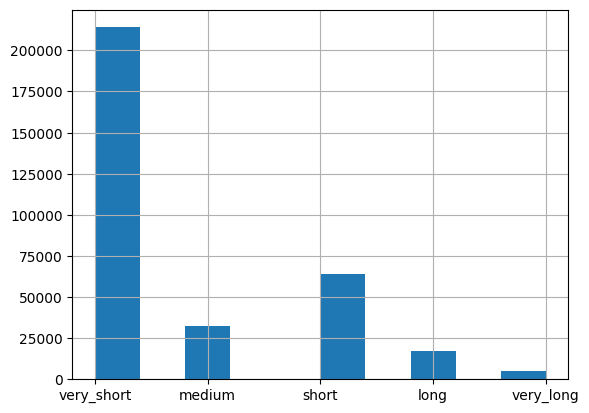

In [13]:
# распределение времени визита по категориям
df['visitDuration_category'].hist()

In [14]:
# операционные системы

df['operatingSystemRoot'].value_counts()

operatingSystemRoot
android             163878
windows              95060
ios_double           63293
macos                 7226
gnu_linux             2867
Нет данных             163
google_chrome_os         9
tizen                    3
firefox_os               2
bsd                      1
Name: count, dtype: Int64

In [15]:
# Категоризируем операционные системы

def categorize_os(os):
    if os == 'ios_double':
        return 'ios'
    elif os == 'gnu_linux':
        return 'linux'
    elif os == 'android' or os == 'windows' or os == 'macos' or os == 'Нет данных':
        return os
    else:
        return 'Другое'

df['operatingSystem_category'] = df['operatingSystemRoot'].apply(categorize_os)

<Axes: >

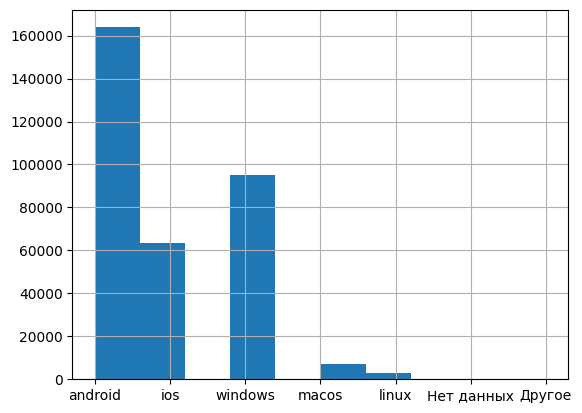

In [16]:
# распределение по типу ОС
df['operatingSystem_category'].hist()

In [17]:
# Категоризируем тип устройства

def categorize_os(os):
    if os == 'ios_double' or os == 'android' or os == 'firefox_os' :
        return 'mobile'
    elif os == 'windows' or os == 'macos' or os == 'gnu_linux' or os == 'google_chrome_os' or os == 'tizen' or os == 'bsd':
        return 'desktop'
    else:
        return 'Нет информации'

df['type_device'] = df['operatingSystemRoot'].apply(categorize_os)

<Axes: >

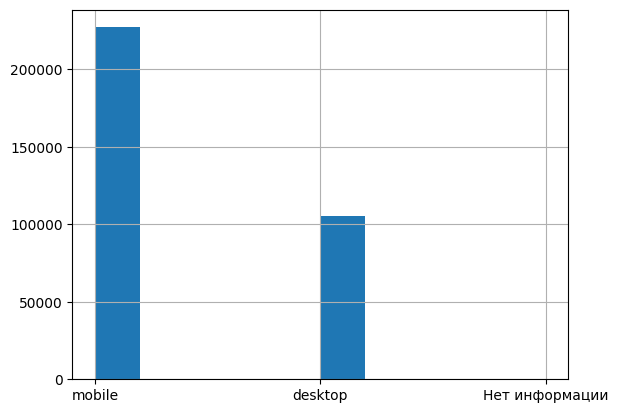

In [18]:
# распределение по типу устройства
df['type_device'].hist()

In [19]:
# распределение пользователей по странам
df['regionCountry'].value_counts()/len(df['regionCountry'])

# среди стран превалирует Россия; скорее всего, остальное - это использование ВПН; страна - незначимый признак

regionCountry
Russia        0.897237
Germany       0.016833
China         0.013624
Finland       0.013567
Kazakhstan    0.010653
                ...   
Syria         0.000003
Lebanon       0.000003
Nicaragua     0.000003
Nepal         0.000003
Zambia        0.000003
Name: count, Length: 102, dtype: Float64

In [20]:
# распределение по городам
df['regionCity'].value_counts().head(10)

# городов очень много - более 1600 - будем использовать частотное кодирование

regionCity
Нет данных          84925
Moscow              68199
Saint Petersburg    24375
Nizhny Novgorod      9079
Yekaterinburg        7487
Novosibirsk          6144
Krasnodar            5097
Helsinki             4382
Domodedovo           4349
Hong Kong            4159
Name: count, dtype: Int64

In [21]:
# распределение по типу источника трафика
df['lastTrafficSource'].value_counts()

lastTrafficSource
organic      178846
direct        63800
ad            44053
internal      35449
referral       6805
social         1963
email          1259
messenger       217
recommend       108
saved             2
Name: count, dtype: Int64

In [22]:
# выделим домены, с которых приходили пользователи
df['referer_domain'] = df['referer'].apply(lambda x: urlparse(str(x)).netloc)
df['referer_domain'].value_counts().head(50)

# видим, что lastTrafficSource достаточно, можно не использовать referer

referer_domain
yandex.ru                                  113542
google.com                                  77277
                                            73024
education.maximumtest.ru                    25208
ya.ru                                        6368
google.ru                                    4545
pruffme.com                                  2743
maximumtest.ru                               2643
login.maximumtest.ru                         2294
propostuplenie.ru                            1885
maximumtest-ru.turbopages.org                1710
propostuplenie-ru.turbopages.org             1704
away.vk.com                                  1189
yandex.by                                    1096
profile.maximumtest.ru                        956
dzen.ru                                       935
bing.com                                      879
yandex.kz                                     853
go.mail.ru                                    780
com.google.android.googlequicksearc

In [23]:
# распределение значений кол-ва регистраций
df['total_regs'].value_counts()

total_regs
0     331099
1       1218
2        154
3         13
4          9
5          6
11         1
13         1
6          1
Name: count, dtype: int64

In [24]:
# Почти у всех пользователей 0 или 1 регистрация, объединим в бинарный признак "есть регистрация" или "нет" 
df['has_registration'] = df['total_regs'].apply(lambda x: 1 if x > 0 else 0)

In [25]:
# анализ UTMSource
filtered = df[df['UTMSource'] != 'Нет данных']
proportions = filtered['UTMSource'].value_counts(normalize=True)
proportions.head(10)

# оставим только самые частые значения (составляют 90%)
top_values = [
    'Нет данных', 
    'yandex', 
    'mindbox', 
    'ya-zen', 
    'Yandex',
    'yandex-direct']

df['UTMSource_category'] = df['UTMSource'].where(df['UTMSource'].isin(top_values), 'Другое')

In [26]:
# Добавление доп признаков после обучения модели первого этапа
# Эффективности признаки не показали, поэтому использовать не будем

# df = df.sort_values(['clientID', 'dateTime'])

# 1. Номер сессии (визита) для каждого пользователя
# df['session_number'] = df.groupby('clientID').cumcount() + 1

# визиты ДО
# df['visits_to_date'] = (df.groupby('clientID').cumcount()).fillna(0)

# отказы ДО визита
# df['bounce'] = df['bounce'].astype(int)
# df['bounces_to_date'] = (
#     df.groupby('clientID')['bounce']
#     .cumsum()  # cumulative sum
#     .sub(df['bounce'])  # исключаем текущую строку
# ).fillna(0)

# длительность просмотра ДО
# df['avg_duration_to_date'] = (df.groupby('clientID')['visitDuration_min'].cumsum().sub(df['visitDuration_min']) / df['visits_to_date']).fillna(0)

# просмотрено страниц ДО
# df['avg_pageviews_to_date'] = (df.groupby('clientID')['pageViews'].cumsum().sub(df['pageViews']) / df['visits_to_date']).fillna(0)

# кампаний ДО
# df['campaign_to_date'] = 0  # сначала заполняем нулями
# df.loc[df['UTMCampaign'] != 'Нет данных', 'campaign_to_date'] = (
#     df[df['UTMCampaign'] != 'Нет данных']
#     .groupby('clientID')
#     .cumcount()
# )

# регистраций ДО
# df['registration_left'] = df['registration_left'].astype(int)
# df['regs_to_date'] = (
#     df.groupby('clientID')['registration_left']
#     .cumsum()  # cumulative sum
#     .sub(df['registration_left'])  # исключаем текущую строку
# ).fillna(0)

# Conversion rate: сколько регистраций на визит
# df['conversion_rate'] = (df['regs_to_date'] / df['visits_to_date']).fillna(0)

# Итоги подготовки данных:

1. Пропуски
в числовых нет, но есть 0
в категориальных - есть пустоты
особенно много в UTMCampaign, UTMContent, UTMMedium, UTMSource, UTMTerm - более 80% - использовать в основном анализе не будем (можно использовать только как бинарный признак, пришёл ли пользователь с рекламной компании или нет).
Можно в дальнейшем расширить анализ до оценки рекламной компании.
Также много пустот в regionCity, referer, mobilePhone - около четверти - использовать следует с осторожностью

2. Дубликатов - нет

3. Выбросы - есть - для части выполнена замена

4. Отрицательных - нет

5. Страны, регионы, устройства, ссылки, даты, кампании заменили на новые признаки

# Часть 2. EDA. Анализ распределений по категориям
# 1. Распределение длительности визита

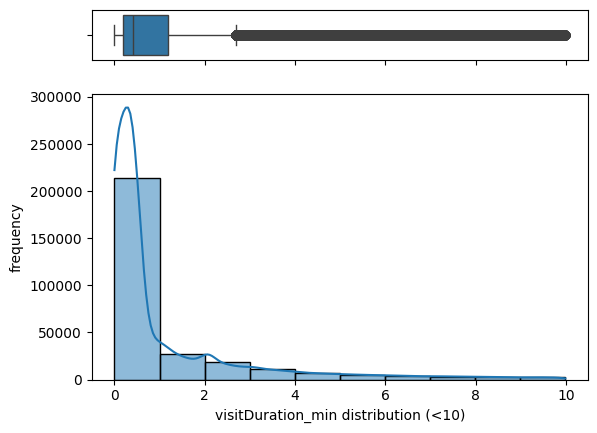

In [27]:
filtered_data = df[df['visitDuration_min'] < 10]['visitDuration_min']

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
sns.boxplot(x=filtered_data, ax=ax_box)
sns.histplot(x=filtered_data, ax=ax_hist, bins=10, kde=True)

ax_box.set(xlabel='')
ax_hist.set(xlabel='visitDuration_min distribution (<10)')
ax_hist.set(ylabel='frequency')
plt.show()


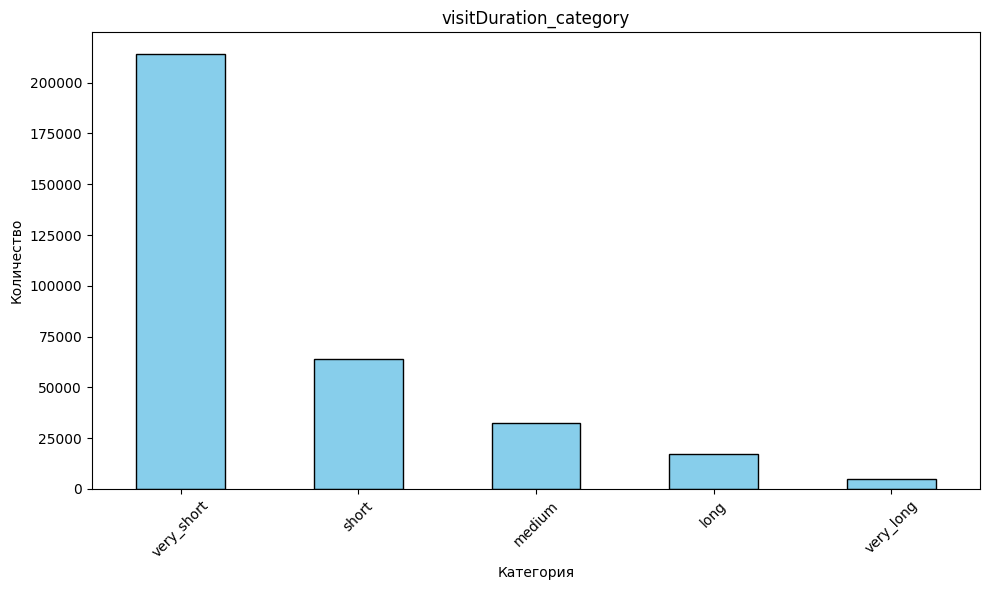

In [28]:
df['visitDuration_category'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), title='visitDuration_category'
)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Распределение ассиметричное, правостороннее
# В основном посещения сайта краткие, менее 1 минуты, но есть выбросы

# 2. Наличие регистрации

<Axes: ylabel='count'>

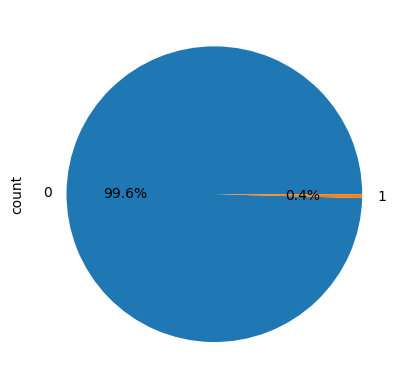

In [29]:
df['has_registration'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# Очень малое количество пользователей оставляет регистрации
# Возможные причины: UX, недоверие, отсутствие заинтересованности к компании
# Рекомендумые действия: сегментация пользователей / исследование последовательности действий пользователей, которые оставили и не оставили регистрации, сравнение групп / проведение A/B-тестирования вариантов формы регистрации, CTA, последовательности действий.

# 3. Распределение кол-ва просмотренных страниц

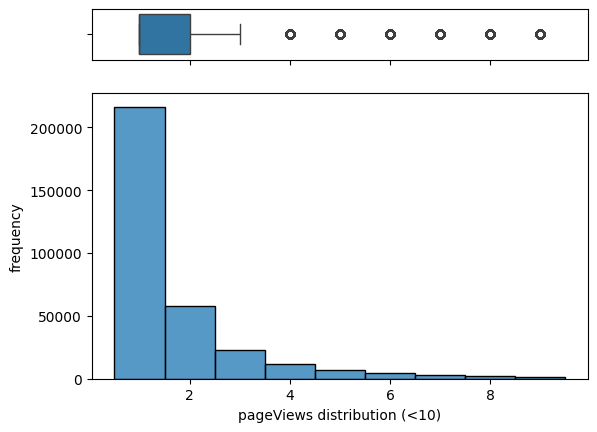

In [30]:
filtered_data = df[df['pageViews'] < 10]['pageViews'].astype(int)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
sns.boxplot(x=filtered_data, ax=ax_box)
sns.histplot(x=filtered_data, ax=ax_hist, bins=np.arange(filtered_data.min(), filtered_data.max() + 2) - 0.5, discrete=True)

ax_box.set(xlabel='')
ax_hist.set(xlabel='pageViews distribution (<10)')
ax_hist.set(ylabel='frequency')
plt.show()


# распределение просмотренных страниц аналогично распределению длительности визита
# 50% пользователей просматривают не более 2 страниц, очень редкие пользователи просматривают более 3 страниц
# рекомендумые действия: анализ последовательности страниц с целью выявить, с каких страниц пользователи чаще всего уходят, чтобы оптимизировать путь пользователей и удержать их на сайте

# 4. Распределение источника трафика

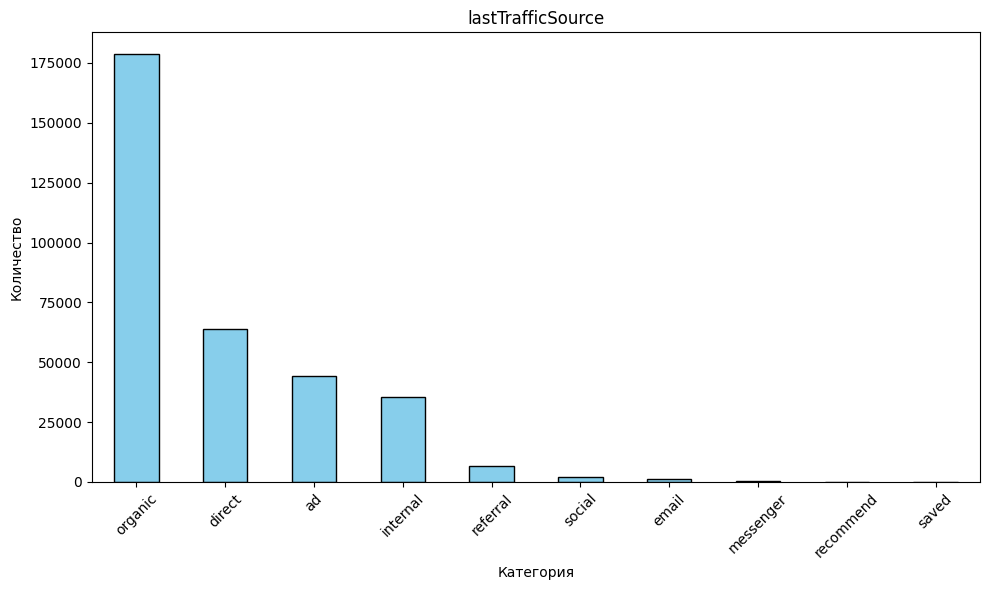

In [31]:
df['lastTrafficSource'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), title='lastTrafficSource'
)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
df['lastTrafficSource'].value_counts()/len(df['lastTrafficSource'])

lastTrafficSource
organic      0.537879
direct       0.191879
ad           0.132489
internal     0.106613
referral     0.020466
social       0.005904
email        0.003786
messenger    0.000653
recommend    0.000325
saved        0.000006
Name: count, dtype: Float64

# 4 категории занимают больше 90% - можно объединить остальное в "Другое"
# основная часть аудитории (54%) - органический поиск; значительная часть из прямого трафика (19%), рекламы (13%), внутреннего (11%)
# малая часть пользователей из соц сетей, реферального трафика, почты, мессенджеров, рекомендательных блоков - это могут быть точки роста, если для данной ЦА такие источники трафика работают 
# рекомендумые действия: запуск кампаний в соцсетях, мессенджерах и отслеживание конверсии

In [33]:
# Категоризируем тип трафика

def categorize_source(source):
    if source == 'organic' or source == 'direct' or source == 'ad' or source == 'internal':
        return source
    else:
        return 'Other'

df['Source'] = df['lastTrafficSource'].apply(categorize_source)

# 5. День недели

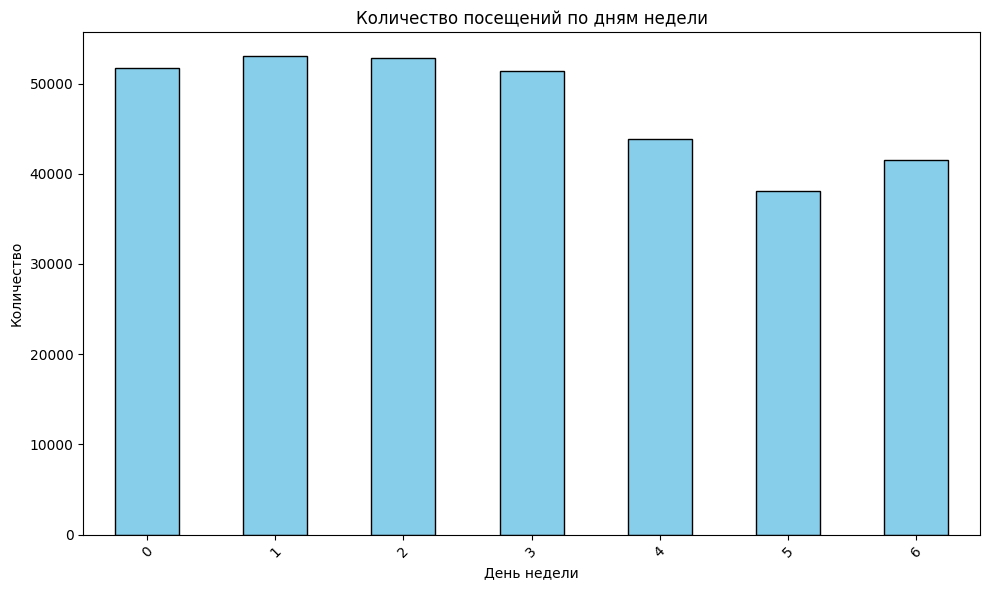

In [34]:
df['weekday'].value_counts().sort_index().plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), title='Количество посещений по дням недели'
)
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

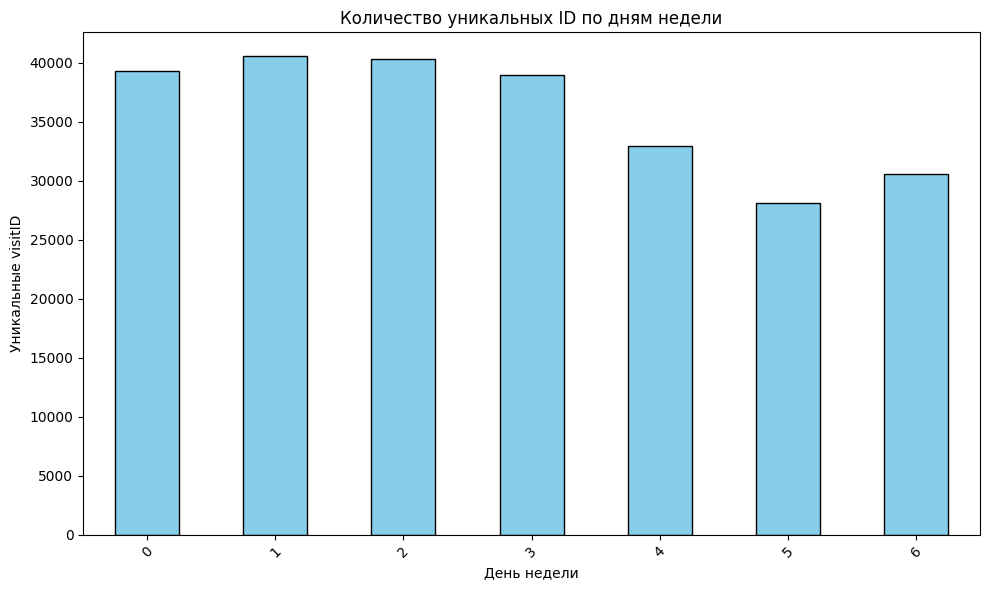

In [35]:
df.groupby('weekday')['clientID'].nunique().sort_index().plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), title='Количество уникальных ID по дням недели'
)
plt.xlabel('День недели')
plt.ylabel('Уникальные visitID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# трафик почти не отличается по дням недели, но к выходным есть некоторая просадка

# 6. Время суток

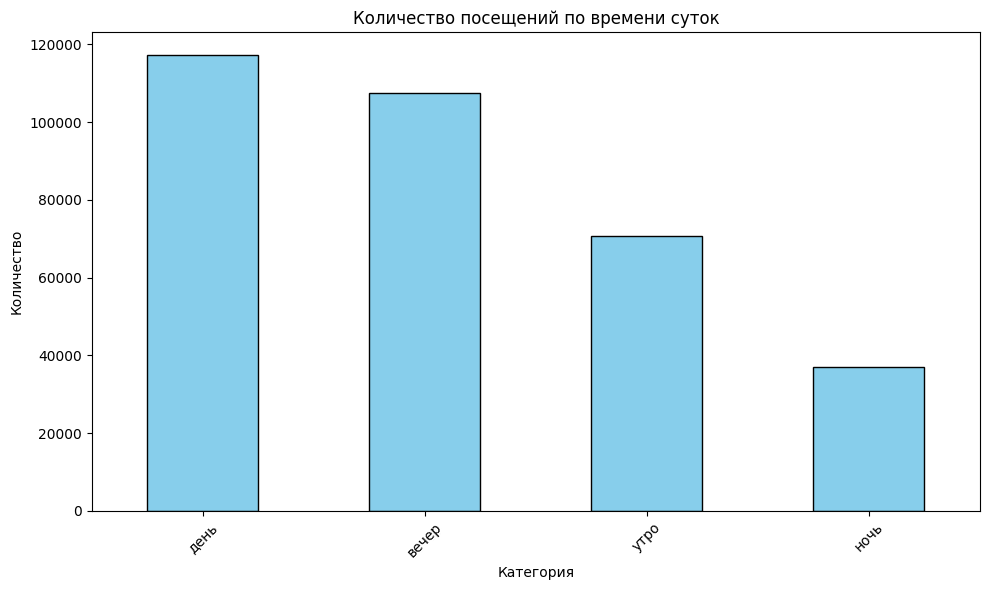

In [36]:
df['day_period'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), title='Количество посещений по времени суток'
)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

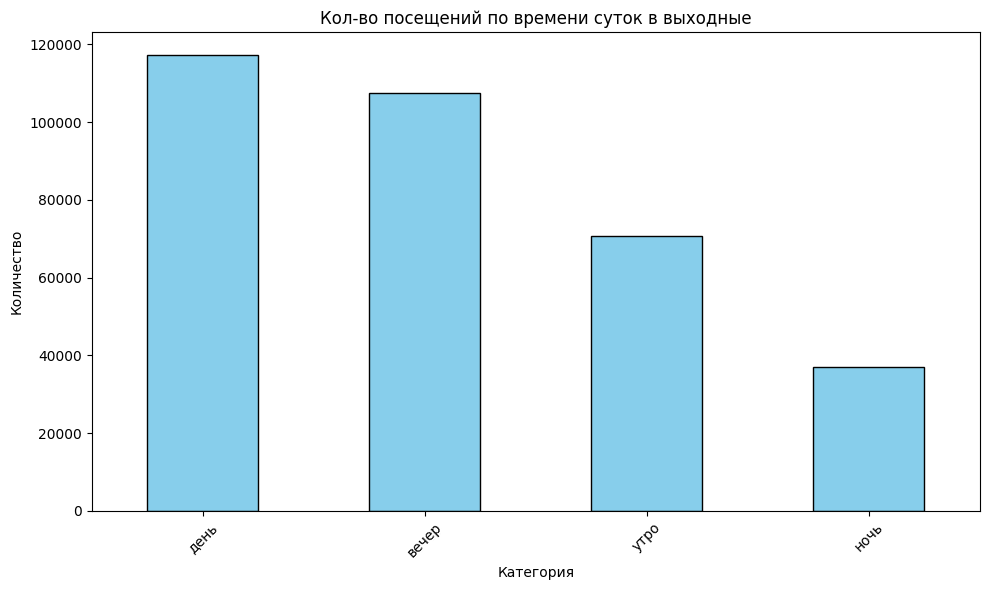

In [37]:
filtered_data = df[df['is_weekend'] == 1]['day_period']

df['day_period'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), 
    title='Кол-во посещений по времени суток в выходные'
)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

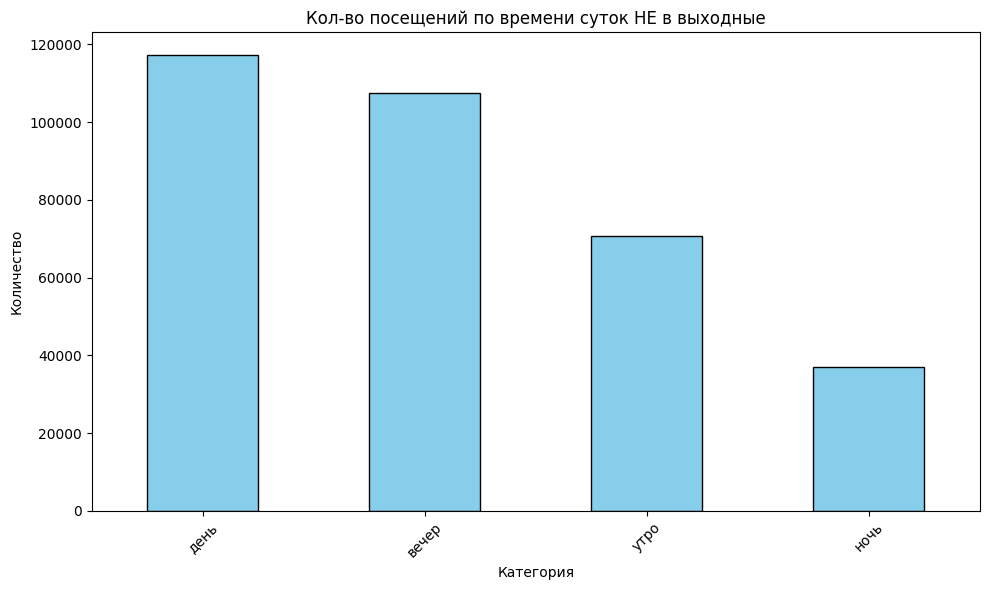

In [38]:
filtered_data = df[df['is_weekend'] == 0]['day_period']

df['day_period'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), 
    title='Кол-во посещений по времени суток НЕ в выходные'
)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# день и вечер выше по трафику и примерно равны друг с другом, вне зависимости от выходных или будней

# 7. Тип устройства и операционная система

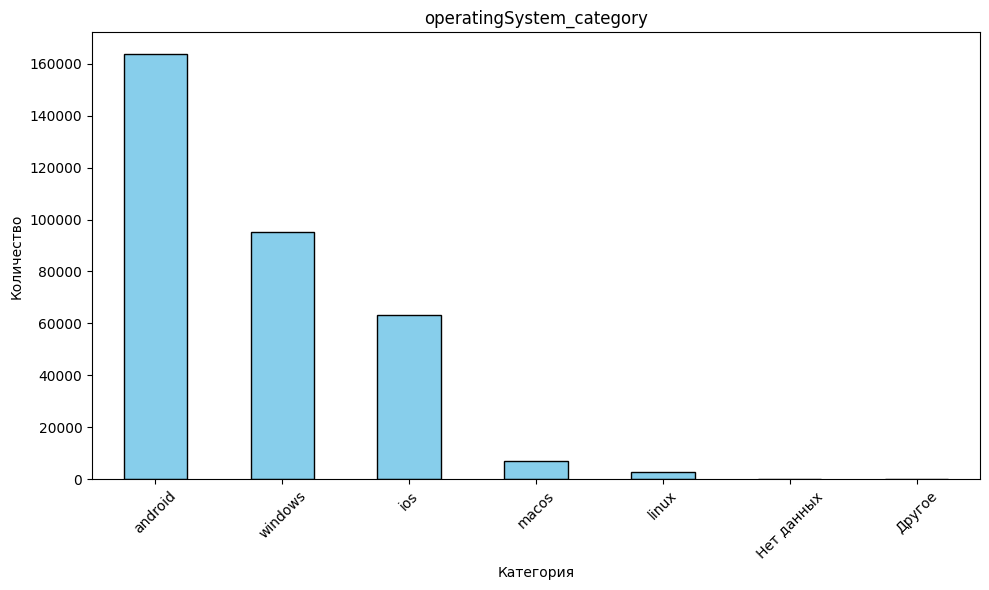

In [39]:
df['operatingSystem_category'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), title='operatingSystem_category'
)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

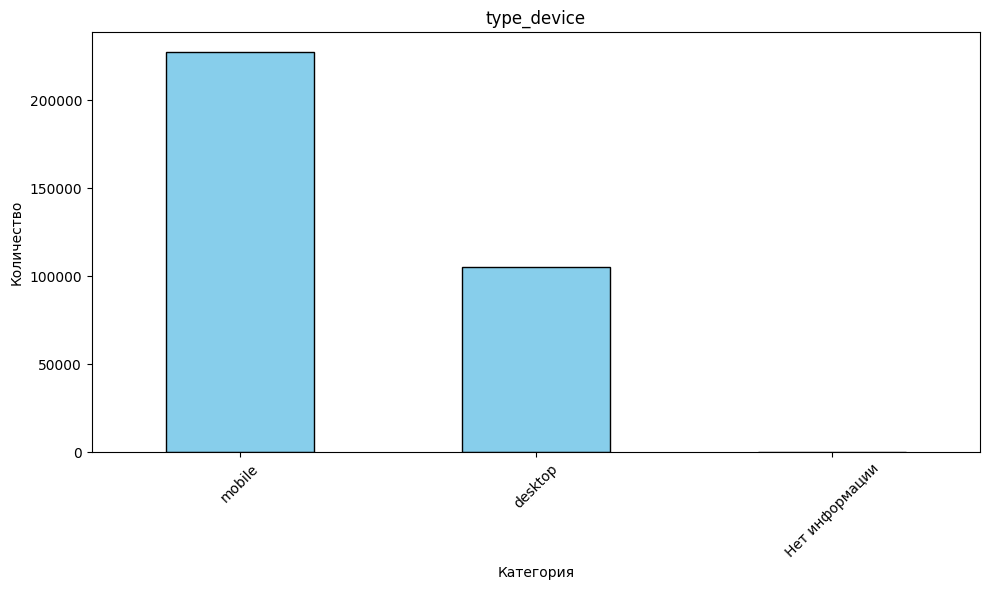

In [40]:
df['type_device'].value_counts().sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6), title='type_device'
)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# пользователей с мобильных устройств в 2 раза больше - нужно уделять внимание адаптации сайта для мобильных устройств и отслеживанию ошибок
# бОльшая часть пользователей с android или windows, но есть также доля с ios - нужно поддерживать все платформы

# 8. Новые/старые пользователи

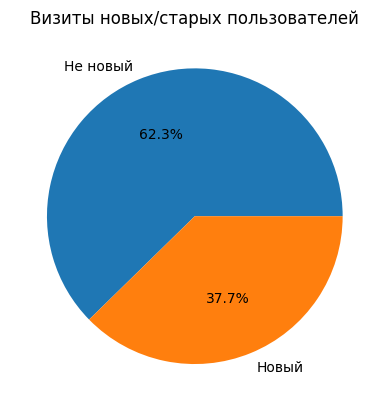

In [41]:
ax = df['isNewUser'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Не новый', 'Новый'])
ax.set_title('Визиты новых/старых пользователей')
plt.ylabel('')
plt.show()

# Новых пользователей в 2 раза больше, но старых пользователей тоже много

# 9. Визитов с отказом

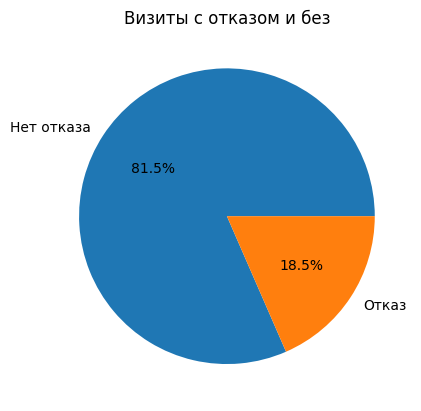

In [42]:
ax = df['bounce'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Нет отказа', 'Отказ'])
ax.set_title('Визиты с отказом и без')
plt.ylabel('')
plt.show()

# довольно большой %отказов - это может влиять на посещения и покупки, нужно выяснить причины и устранить; далее будет более подробный анализ отказов по устройствам 
# рекоменуемые действия: сегментировать отказы по страницам; проверить технические обновления сайта в периоды с большим кол-вом отказов; можно провести UX-аудит и юзабилити-тест

# 10. Визиты на выходных/будних днях

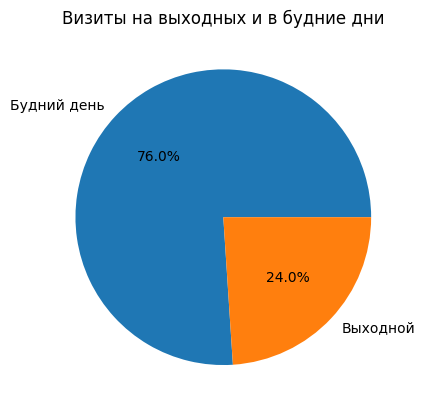

In [43]:
ax = df['is_weekend'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Будний день', 'Выходной'])
ax.set_title('Визиты на выходных и в будние дни')
plt.ylabel('')
plt.show()

# четверть визитов приходится на выходные дни

# Часть 3. EDA. Анализ временных рядов

# 1. Визиты и проведение кампаний по месяцам

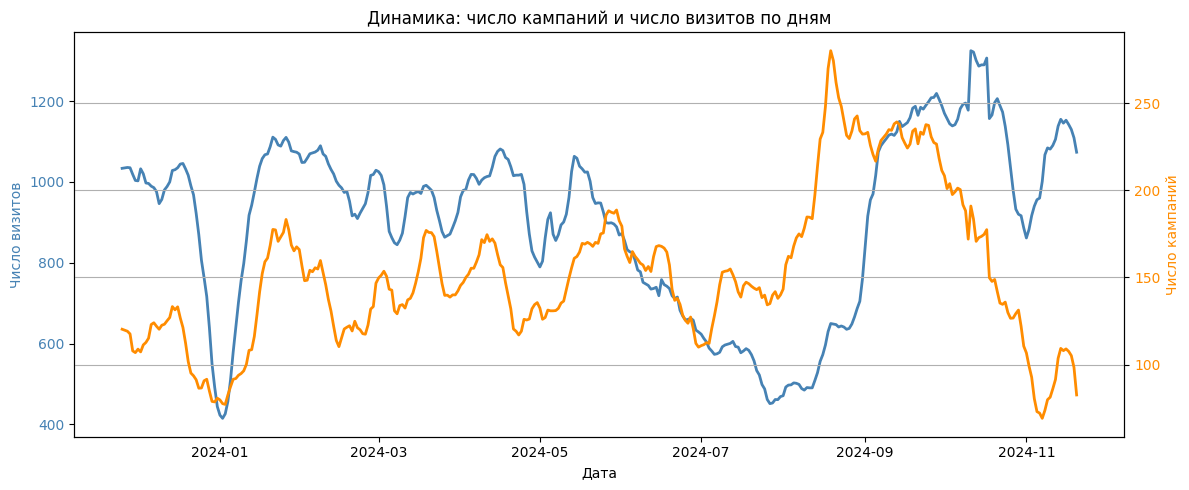

In [44]:
daily_visits = df.groupby('date')['visitID'].count()
df_filtered = df[df['UTMSource'] != 'Нет данных']
daily_compaign = df_filtered.groupby('date')['UTMSource_category'].count()

# скользящее среднее
smoothed_visits = daily_visits.rolling(window=7, center=True).mean()
smoothed_metric = daily_compaign.rolling(window=7, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(smoothed_visits, color='steelblue', linewidth=2, label='Число визитов')
ax1.set_ylabel('Число визитов', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Вторая ось
ax2 = ax1.twinx()
ax2.plot(smoothed_metric, color='darkorange', linewidth=2, label='Число кампаний')
ax2.set_ylabel('Число кампаний', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('Динамика: число кампаний и число визитов по дням')
ax1.set_xlabel('Дата')
fig.tight_layout()
plt.grid(True)
plt.show()

# Наблюдается провал визитов в январе (из-за праздников)
# Также провал в июне-августе (снижение активности летом)
# Есть провал в ноябре
# Скачок визитов в сентябре-октябре - коррелирует с проведением кампании

# В целом видим, что визиты коррелируют с кампаниями, немного запаздывая за ними - это говорит об успешности кампаний
# Рекомендуемые действия: узнать даты проведения кампаний, чтобы исследовать запаздывание реакции на кампанию (дней в среднем от начала проведения до пика визитов) - чтобы точнее планировать будущие запуски и нагрузку отдела продаж

# 2. Визиты и доля отказов по месяцам

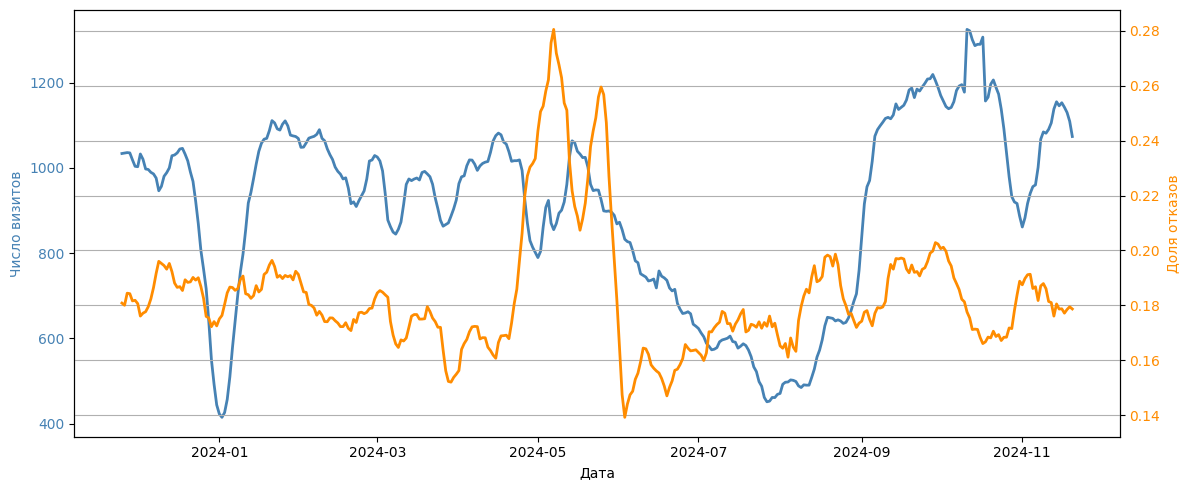

In [45]:
daily_total = df.groupby('date').size()
daily_bounce = df[df['bounce'] == 1].groupby('date').size()
daily_bounce_prop = (daily_bounce / daily_total).fillna(0)

daily_visits = df.groupby('date')['visitID'].count()

# скользящее среднее
smoothed_visits = daily_visits.rolling(window=7, center=True).mean()
smoothed_metric = daily_bounce_prop.rolling(window=7, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(smoothed_visits, color='steelblue', linewidth=2, label='Число визитов')
ax1.set_ylabel('Число визитов', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(smoothed_metric, color='darkorange', linewidth=2, label='Доля отказов')
ax2.set_ylabel('Доля отказов', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

ax1.set_xlabel('Дата')
fig.tight_layout()
plt.grid(True)
plt.show()

# наибольшее кол-во сбоев было в мае-июне; при этом кол-во визитов оставалось большим
# также много сбоев было в конце августа-начале сентября, кол-во визитов при этом снизилось - это важный маркер, т.к. именно к началу учебного года пользователи готовы покупать курсы - нужно выяснить причину отказов
# в остальное время чем больше визитов - тем больше и отказов

# рекомедуемые действия: технический аудит по пикам сбоев (какие именно сбои, насколько критичны); возможно, ввести или проапгрейдить мониторинг и алерты

# 3. Кол-во регистраций и отказов по месяцам

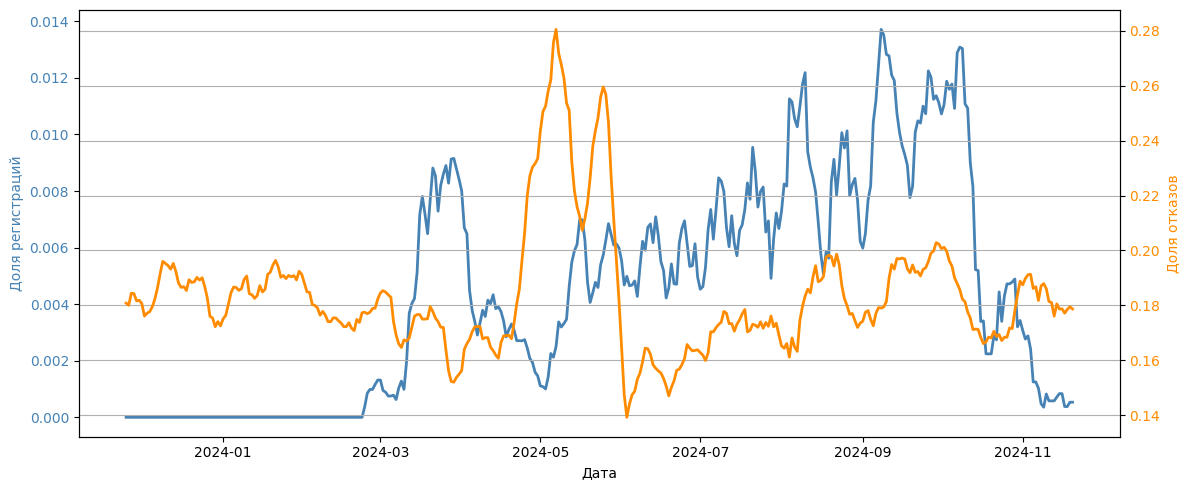

In [46]:
daily_total = df.groupby('date').size()
daily_bounce = df[df['bounce'] == 1].groupby('date').size()
daily_bounce_prop = (daily_bounce / daily_total).fillna(0)

daily_reg = df[df['registration_left'] == 1].groupby('date').size()
daily_reg_prop = (daily_reg / daily_total).fillna(0)

# скользящее среднее
smoothed_visits = daily_reg_prop.rolling(window=7, center=True).mean()
smoothed_metric = daily_bounce_prop.rolling(window=7, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(smoothed_visits, color='steelblue', linewidth=2, label='Доля регистраций')
ax1.set_ylabel('Доля регистраций', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(smoothed_metric, color='darkorange', linewidth=2, label='Доля отказов')
ax2.set_ylabel('Доля отказов', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

ax1.set_xlabel('Дата')
fig.tight_layout()
plt.grid(True)
plt.show()

# в период отказов регистрации также падали - это говорит о необходимости следить за работой сайта
# падение регистраций также было в ноябре, но это связано с падением кол-ва визитов

# 4. Регистрации и проведение кампаний по месяцам

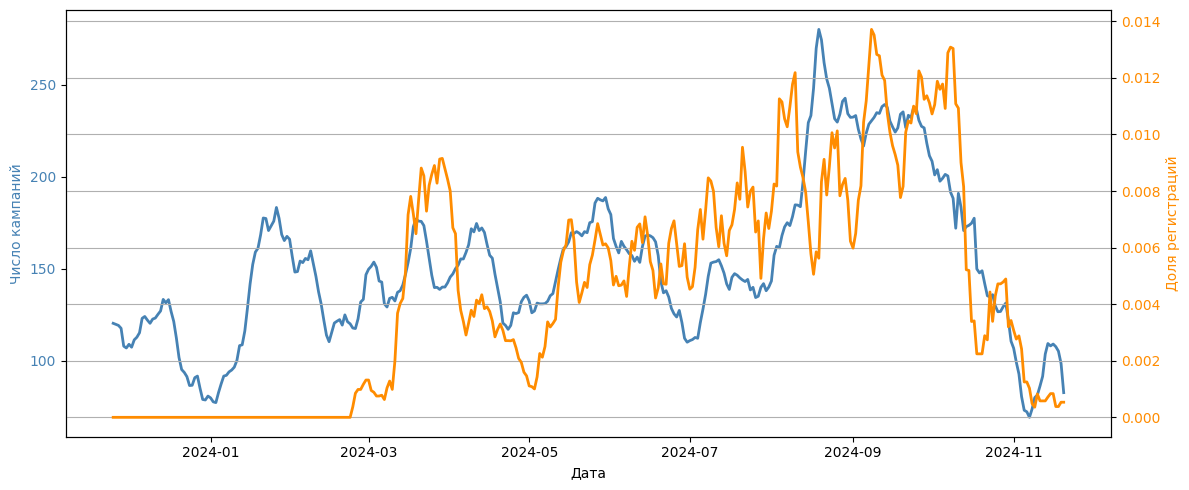

In [47]:
daily_total = df.groupby('date').size()
df_filtered = df[df['UTMSource'] != 'Нет данных']
daily_compaign = df_filtered.groupby('date')['UTMSource_category'].count()

daily_reg = df[df['registration_left'] == 1].groupby('date').size()
daily_reg_prop = (daily_reg / daily_total).fillna(0)

# скользящее среднее
smoothed_compaign = daily_compaign.rolling(window=7, center=True).mean()
smoothed_reg = daily_reg_prop.rolling(window=7, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(smoothed_compaign, color='steelblue', linewidth=2, label='Число кампаний')
ax1.set_ylabel('Число кампаний', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(smoothed_reg, color='darkorange', linewidth=2, label='Доля регистраций')
ax2.set_ylabel('Доля регистраций', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

ax1.set_xlabel('Дата')
fig.tight_layout()
plt.grid(True)
plt.show()

# в феврале были кампании, но нет регистраций - или регистрации не фиксировались, или кампания не работала
# рекомендуемые действия: проверить корректность трекинга событий и данных по кампаниям (например, сбои в UTM-метках)

# резкий спад в ноябре из-за спада визитов в целом

# интересно, что доля регистраций была высокой в апреле - видимо, в преддверии экзаменов и вследствие проведения кампаний
# также доля регистраций повышается к началу учебного года (к осени) - в это время точно нужно устраивать кампании
# во время проведения кампаний доля регистраций также растёт

# 5. Средние кол-ва просмотренных страниц и длительность визитов по месяцам

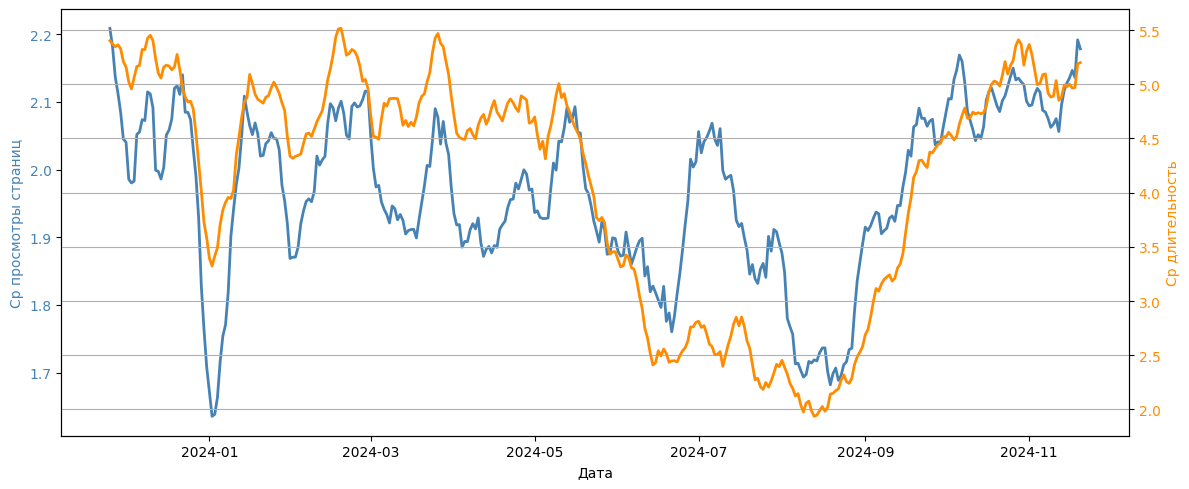

In [48]:
daily_visits = df.groupby('date')['pageViews'].mean()
daily_compaign = df.groupby('date')['visitDuration_min'].mean()

smoothed_visits = daily_visits.rolling(window=7, center=True).mean()
smoothed_metric = daily_compaign.rolling(window=7, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(smoothed_visits, color='steelblue', linewidth=2, label='Ср просмотры страниц')
ax1.set_ylabel('Ср просмотры страниц', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(smoothed_metric, color='darkorange', linewidth=2, label='Ср длительность')
ax2.set_ylabel('Ср длительность', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

ax1.set_xlabel('Дата')
fig.tight_layout()
plt.grid(True)
plt.show()

# Количество просмотренных страниц и время сеанса коррелирует с кол-вом визитов на сайт (также есть провал в январе, провал летом; восстановление уровня к осени (не зависит от кампании, такой же уровень поддерживается и зимой-весной))

# Есть интересная особенность: количество просмотренных страниц возрастает летом, хотя визиты и длительность падают; как будто пользователи кратко изучают страницы сайта - вероятно, перед учебным годом ищут курсы для подготовки. В это время логично запускать кампании и к этому времени актуализировать сайт

# Часть 4. EDA. Влияние категорий пользователя на метрики

# 1. Влияние на просмотры страниц

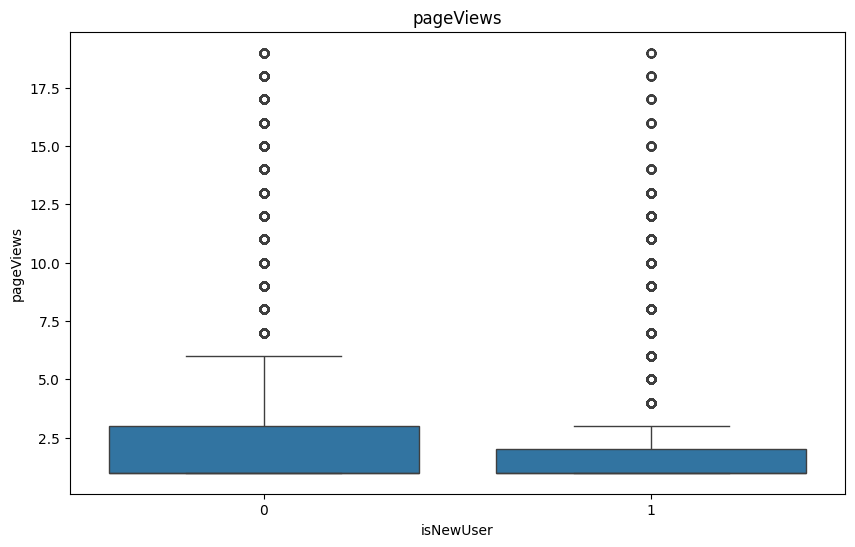

Средний:
isNewUser
0    2.400063
1    1.536714
Name: pageViews, dtype: float64


In [49]:
feature = 'pageViews'
filtered_data = df[df[feature] < 20]

plt.figure(figsize=(10, 6))
sns.boxplot(x='isNewUser', y=feature, data=filtered_data)
plt.title(feature)
plt.show()

print("Средний:")
print(filtered_data.groupby('isNewUser')[feature].mean())

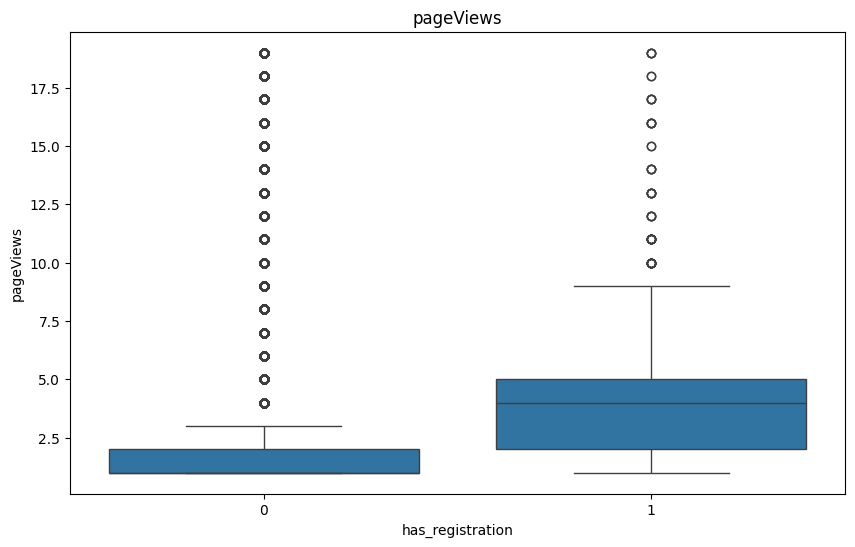

Средний:
has_registration
0    1.851724
1    3.978448
Name: pageViews, dtype: float64


In [50]:
feature = 'pageViews'
filtered_data = df[df[feature] < 20]

plt.figure(figsize=(10, 6))
sns.boxplot(x='has_registration', y=feature, data=filtered_data)
plt.title(feature)
plt.show()

print("Средний:")
print(filtered_data.groupby('has_registration')[feature].mean())

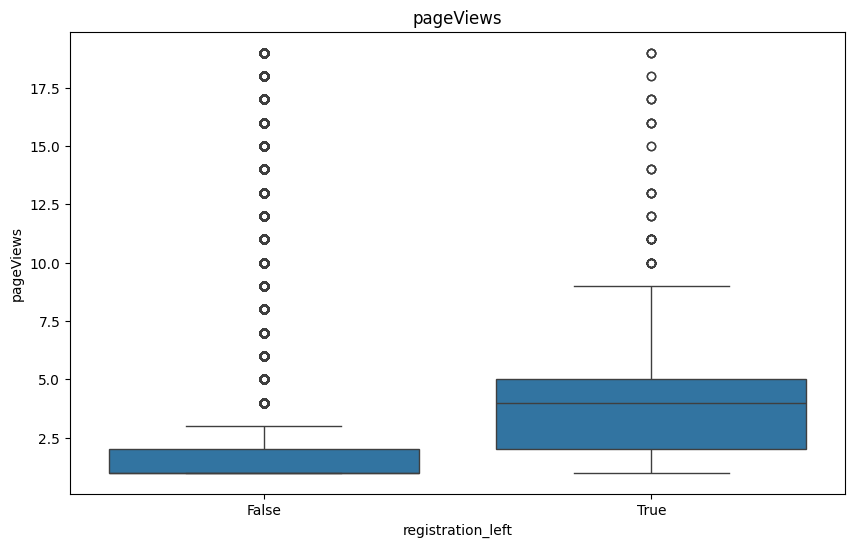

Средний:
registration_left
False    1.851724
True     3.978448
Name: pageViews, dtype: float64


In [51]:
feature = 'pageViews'
filtered_data = df[df[feature] < 20]

plt.figure(figsize=(10, 6))
sns.boxplot(x='registration_left', y=feature, data=filtered_data)
plt.title(feature)
plt.show()

print("Средний:")
print(filtered_data.groupby('registration_left')[feature].mean())

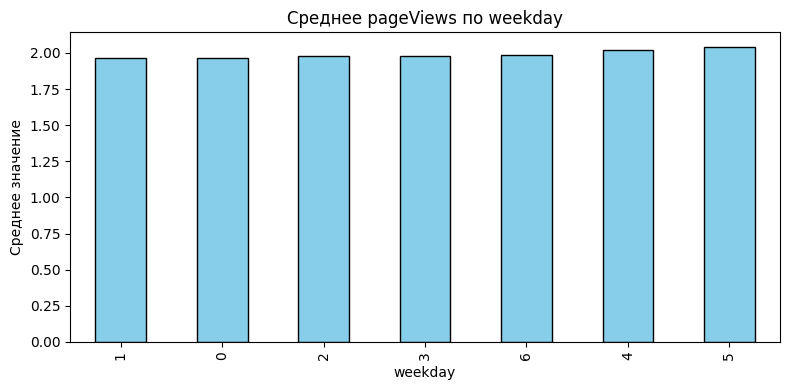

Средний:
weekday
0    1.966392
1    1.965325
2    1.976840
3    1.977648
4    2.018233
5    2.040653
6    1.987927
Name: pageViews, dtype: float64


In [52]:
feature = 'pageViews'
category = 'weekday'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

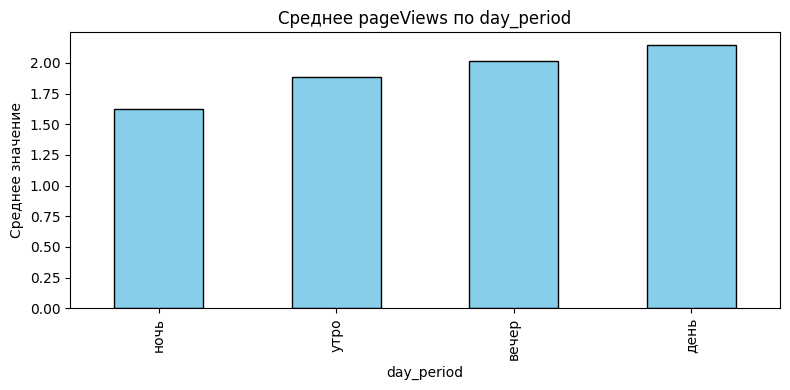

Средний:
day_period
вечер    2.013687
день     2.141935
ночь     1.622430
утро     1.883554
Name: pageViews, dtype: float64


In [53]:
feature = 'pageViews'
category = 'day_period'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

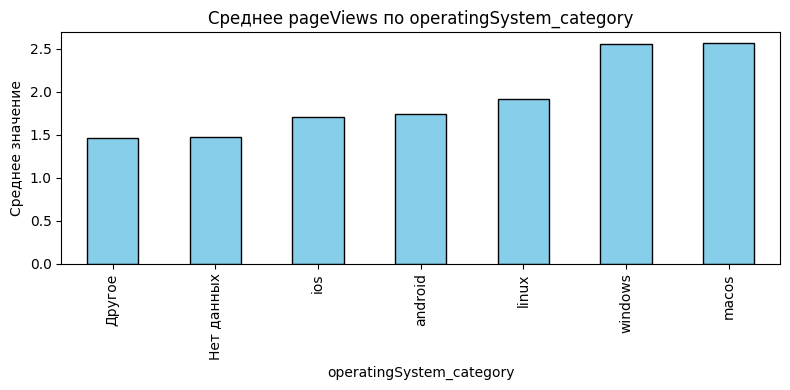

Средний:
operatingSystem_category
android       1.741088
ios           1.712038
linux         1.921172
macos         2.565596
windows       2.555291
Другое        1.466667
Нет данных    1.478528
Name: pageViews, dtype: float64


In [54]:
feature = 'pageViews'
category = 'operatingSystem_category'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

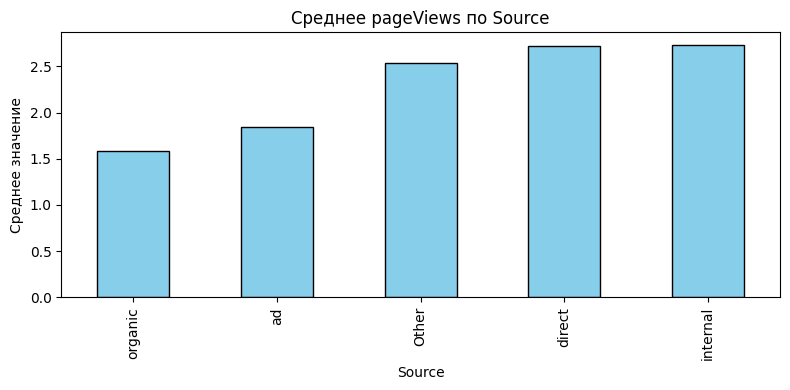

Средний:
Source
Other       2.539791
ad          1.848455
direct      2.724859
internal    2.732856
organic     1.579303
Name: pageViews, dtype: float64


In [55]:
feature = 'pageViews'
category = 'Source'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

# Результаты исследования влияния на просмотр страниц
# 1) Новые пользователи просматривают заметно больше страниц
# Рекомендуемые действия: изучить поведение новых пользователей (какие страницы интересуют больше, какую информацию ищут, на чём чаще задерживаются и какие страницы чаще ведут к регистрации)

# 2) Пользователи, которые оставляют регистрацию или оставляли регистрацию когда-либо, склонны просматривать больше страниц и тщательнее изучать сайт
# Рекомендуемые действия: уделить внимание навигации сайта, полезной информации на нём (изучить длительности визитов конкретных страниц)

# 3) Просмотр страниц не зависит от дня недели; от времени суток зависит незначительно - нагрузка на сайт не возрастает резко в какие-либо дни
# 4) С десктопов смотрят больше страниц, чем с телефона - это интересно, т.к. с телефонов видели больше визитов
# 5) Более заинтересованные пользователи - с direct или internal

# 2. Влияние на длительность визита

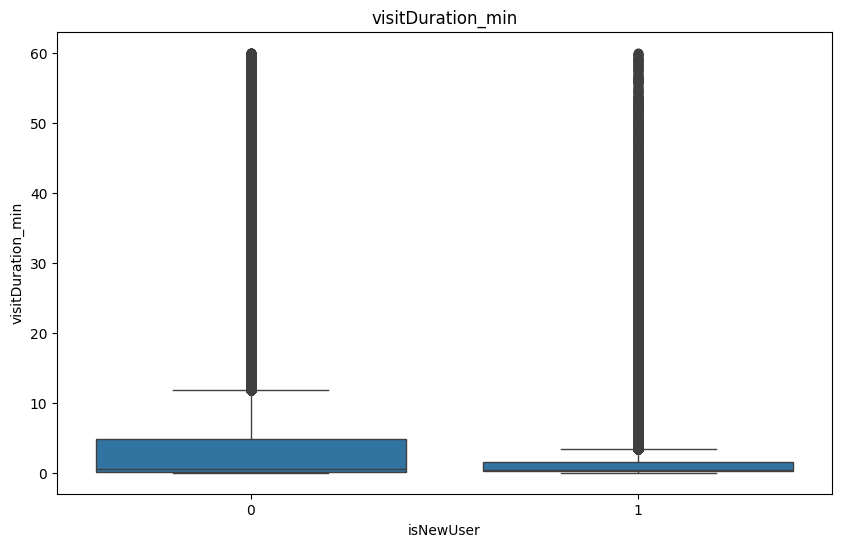

Средний:
isNewUser
0    5.755694
1    2.068275
Name: visitDuration_min, dtype: float64


In [56]:
feature = 'visitDuration_min'
filtered_data = df[df[feature] < 60]

plt.figure(figsize=(10, 6))
sns.boxplot(x='isNewUser', y=feature, data=filtered_data)
plt.title(feature)
plt.show()

print("Средний:")
print(filtered_data.groupby('isNewUser')[feature].mean())

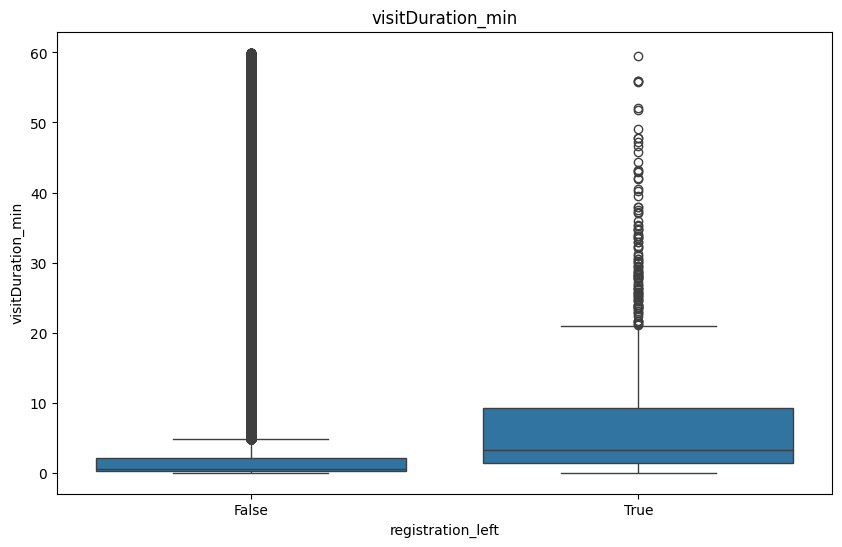

Средний:
registration_left
False    3.410482
True     6.961319
Name: visitDuration_min, dtype: float64


In [57]:
feature = 'visitDuration_min'
filtered_data = df[df[feature] < 60]

plt.figure(figsize=(10, 6))
sns.boxplot(x='registration_left', y=feature, data=filtered_data)
plt.title(feature)
plt.show()

print("Средний:")
print(filtered_data.groupby('registration_left')[feature].mean())

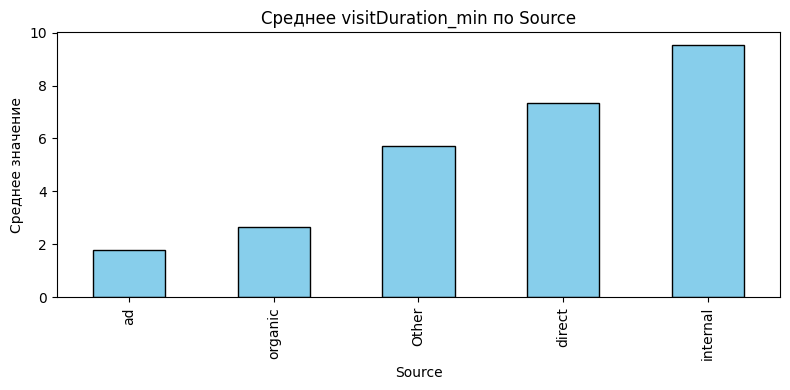

Средний:
Source
Other       5.701668
ad          1.800125
direct      7.354893
internal    9.532826
organic     2.674007
Name: visitDuration_min, dtype: float64


In [58]:
feature = 'visitDuration_min'
category = 'Source'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

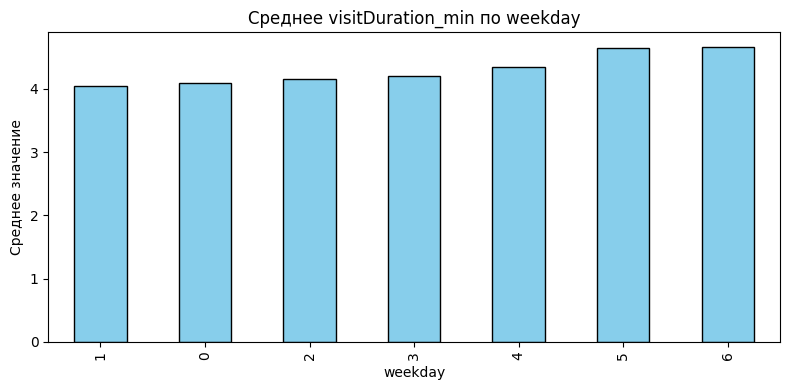

Средний:
weekday
0    4.096174
1    4.048489
2    4.152648
3    4.205891
4    4.350823
5    4.648897
6    4.659801
Name: visitDuration_min, dtype: float64


In [59]:
feature = 'visitDuration_min'
category = 'weekday'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

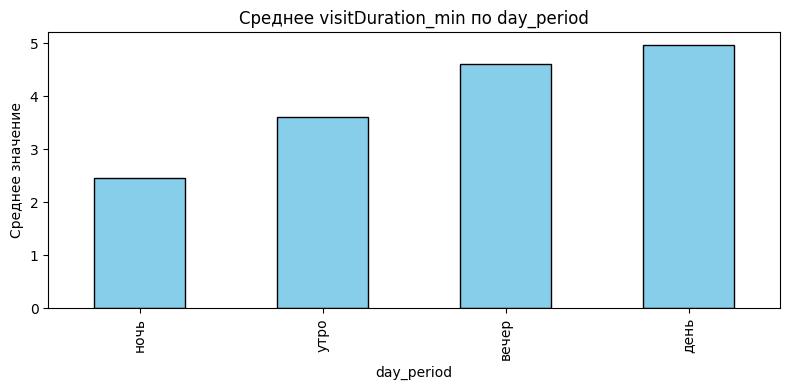

Средний:
day_period
вечер    4.607584
день     4.962136
ночь     2.468252
утро     3.608485
Name: visitDuration_min, dtype: float64


In [60]:
feature = 'visitDuration_min'
category = 'day_period'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

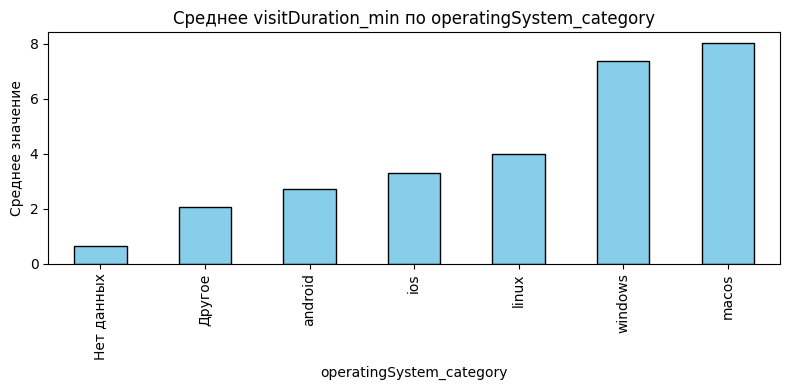

Средний:
operatingSystem_category
android       2.704554
ios           3.283824
linux         3.996611
macos         8.023618
windows       7.396511
Другое        2.050000
Нет данных    0.629448
Name: visitDuration_min, dtype: float64


In [61]:
feature = 'visitDuration_min'
category = 'operatingSystem_category'

df.groupby(category)[feature].mean().sort_values().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Среднее {feature} по {category}'
)
plt.ylabel('Среднее значение')
plt.tight_layout()
plt.show()

print("Средний:")
print(df.groupby(category)[feature].mean())

# Результаты исследования влияния на длительность визита
# 1) Неожиданная закономерность: новые пользователи меньше сидят на сайте, хотя страниц смотрят больше - то есть они просматривают их бегло; 
# Рекомендуемые действия: 
# - проверить гипотезы о том, почему бегло просматривают страницы - это знакомство с компанией / поиск нужной информации / неудобная структура сайта
# - можно протестировать подсказки или контекстные блоки на страницах
# - можно предлагать именно новым пользователям наиболее релевантные страницы со сжатой информацией, которые потом ведут на регистрацию (для этого исследовать, на каких страницах новые пользователи проводят больше времени, до каких доходят и с каких уходят)

# 2) Регистрацию оставляют в основном после длительных просмотров
# Рекомендуемые действия: можно сделать всплывающее предложение о регистрации после определенного интервала просмотра страницы

# 3) Более заинтересованные пользователи - с direct или internal

# 4) От дня недели ничего не зависит; дольше просматривают днем-вечером, что логично

# 5) С десктопа находятся на сайте в несколько раз дольше, чем с мобильных устройств - совпадает с кол-вом просмотренных страниц
# Рекомендуемые действия: провести анализ качества мобильной версии (возможно, она неудобна или не содержит весь функционал)

# 3. Исследование новых пользователей

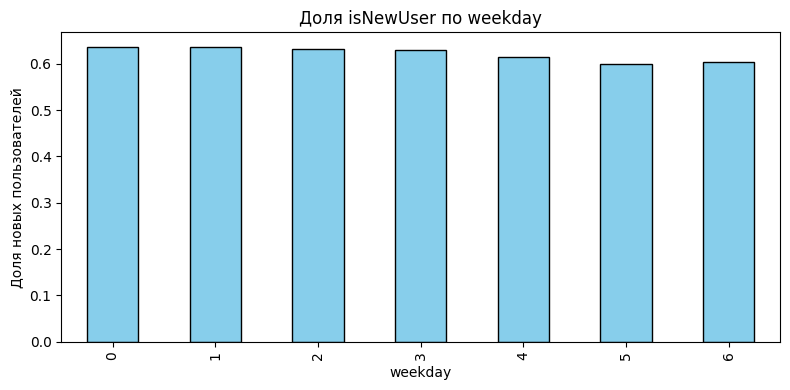

Доля:
weekday
0    0.635352
1    0.635731
2    0.632303
3    0.629821
4    0.614710
5    0.599270
6    0.603478
Name: isNewUser, dtype: float64


In [62]:
feature = 'isNewUser'
category = 'weekday'

df.groupby(category)[feature].mean().plot(
    kind='bar', figsize=(8, 4), color='skyblue', edgecolor='black', title=f'Доля {feature} по {category}'
)
plt.ylabel('Доля новых пользователей')
plt.tight_layout()
plt.show()

print("Доля:")
print(df.groupby(category)[feature].mean())

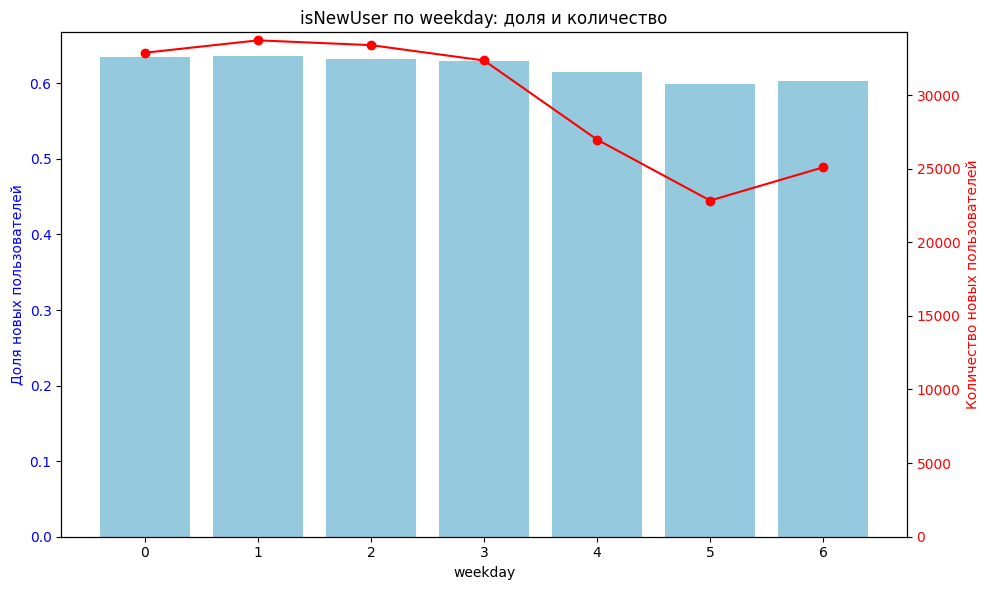

In [63]:
feature = 'isNewUser'
category = 'weekday'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, lambda x: (x == 1).sum())
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля новых пользователей', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество новых пользователей', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


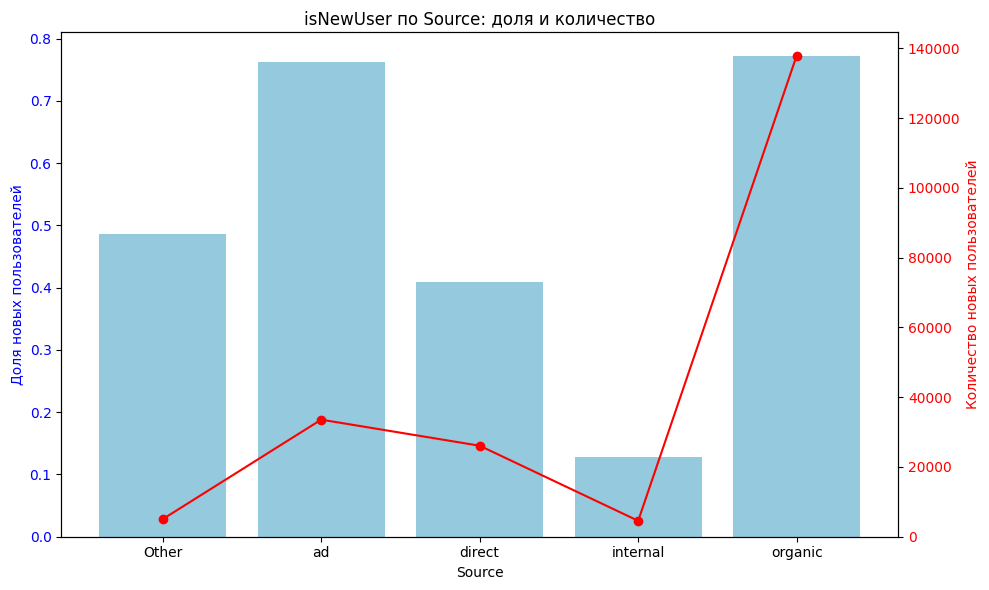

In [64]:
feature = 'isNewUser'
category = 'Source'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, lambda x: (x == 1).sum())
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля новых пользователей', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество новых пользователей', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


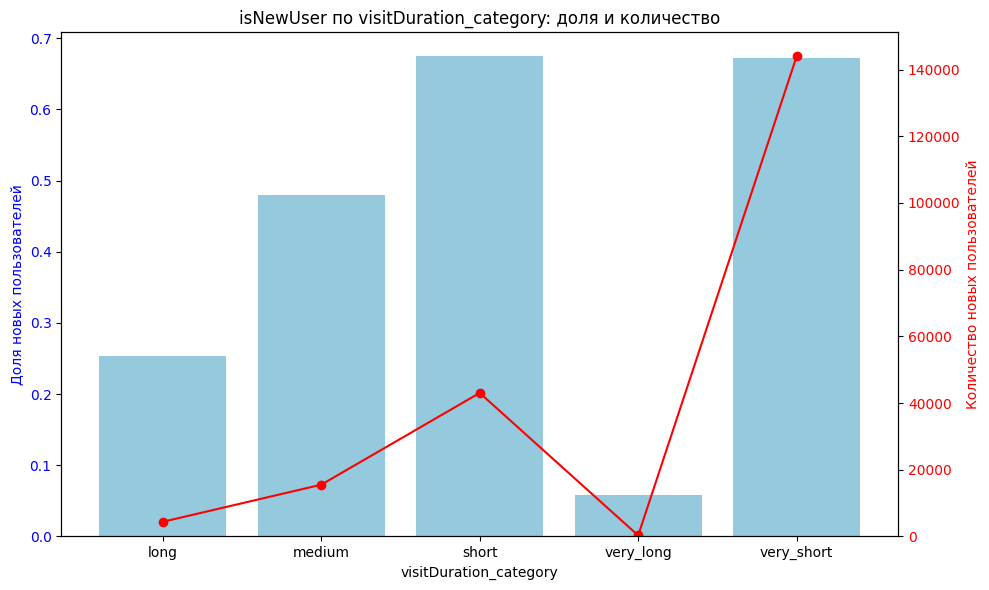

In [65]:
feature = 'isNewUser'
category = 'visitDuration_category'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, lambda x: (x == 1).sum())
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля новых пользователей', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество новых пользователей', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


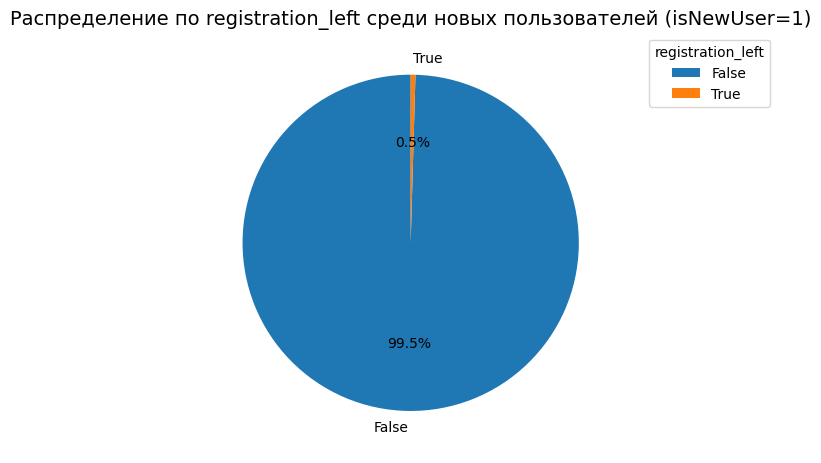

In [ ]:
feature = 'isNewUser'
category = 'registration_left'

df_filter = df[df[feature] == 1]

ax = df_filter[category].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    figsize=(6, 6),
    legend=False,
    ylabel=''
)

plt.title(f'Распределение по {category} среди новых пользователей ({feature}=1)', fontsize=14)
plt.legend(title=category, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


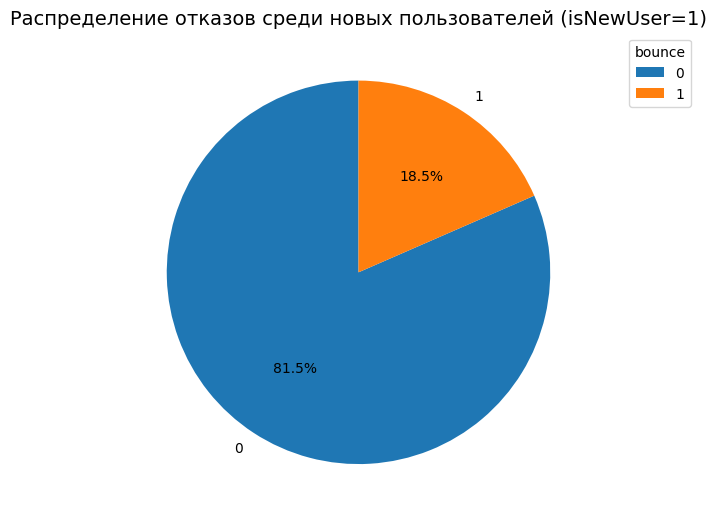

In [ ]:
feature = 'isNewUser'
category = 'bounce'

df_filter = df[df[feature] == 1]

ax = df_filter[category].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    figsize=(6, 6),
    legend=False,
    ylabel=''
)

plt.title(f'Распределение отказов среди новых пользователей ({feature}=1)', fontsize=14)
plt.legend(title=category, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


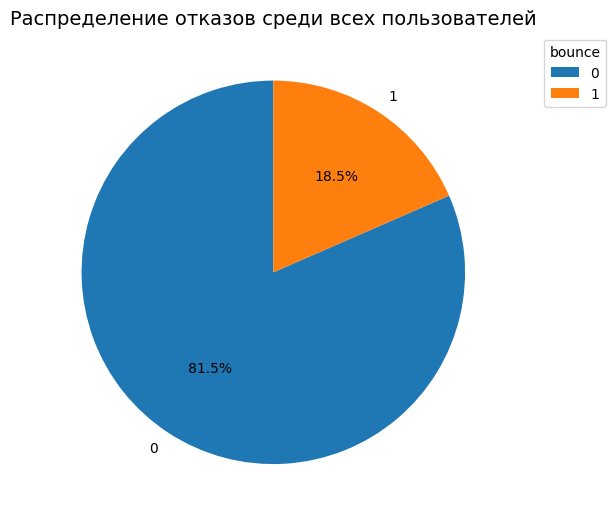

In [68]:
category = 'bounce'

ax = df[category].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    figsize=(6, 6),
    legend=False,
    ylabel=''
)

plt.title(f'Распределение отказов среди всех пользователей', fontsize=14)
plt.legend(title=category, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Влияние кампаний на регистрацию новых пользователей

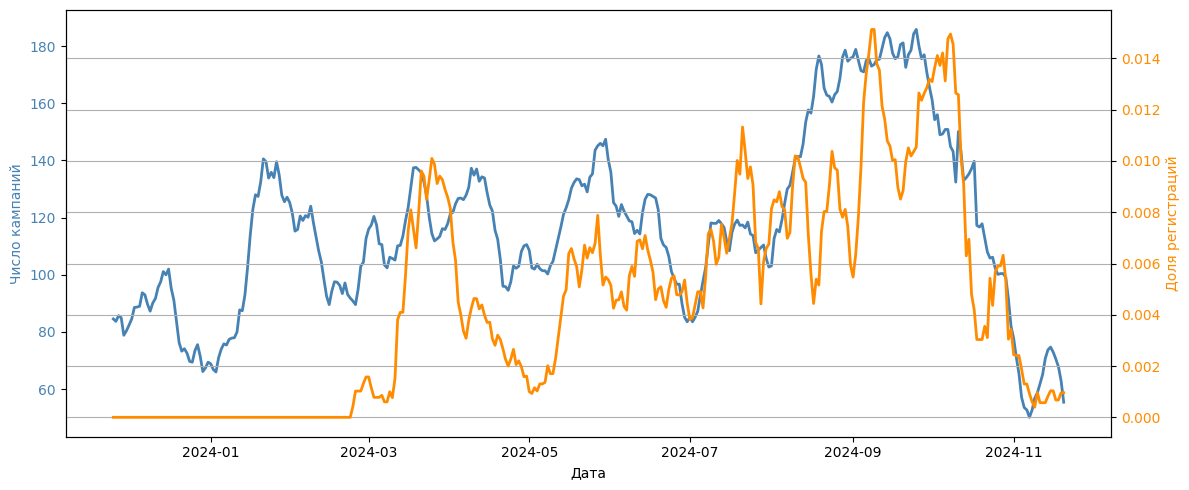

In [70]:
df_new = df[df['isNewUser'] == 1]

daily_total = df_new.groupby('date').size()
df_filtered = df_new[df_new['UTMSource'] != 'Нет данных']
daily_compaign = df_filtered.groupby('date')['UTMSource_category'].count()

daily_reg = df_new[df_new['registration_left'] == 1].groupby('date').size()
daily_reg_prop = (daily_reg / daily_total).fillna(0)

# скользящее среднее
smoothed_compaign = daily_compaign.rolling(window=7, center=True).mean()
smoothed_reg = daily_reg_prop.rolling(window=7, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(smoothed_compaign, color='steelblue', linewidth=2, label='Число кампаний')
ax1.set_ylabel('Число кампаний', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(smoothed_reg, color='darkorange', linewidth=2, label='Доля регистраций')
ax2.set_ylabel('Доля регистраций', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

ax1.set_xlabel('Дата')
fig.tight_layout()
plt.grid(True)
plt.show()

# Результаты исследования поведения новых пользователей
# 1. Новые пользователи заходят на сайт в любой день примерно одинаково, на выходных меньше (как и в целом все пользователи)
# 2. Основные источники привлечения - ogranic, ad; реже - direct, other
# 3. Как уже уже выясняли, новые пользователи не сидят на сайте долго, хотя страниц просматривают много - самая полезная информация, наша экспертиза, предложения должны быть видны на страницах сразу
# 4. Регистраций оставляют крайне мало
# 5. Отказов у новых пользователей столько же, как и по системе
# 6. Проведение кампаний также приводит к привлечению ЦА и повышению регистраций; пики совпадают с общим поведением пользователей, новые пользователи не выделяются

# 4. Исследование отказов

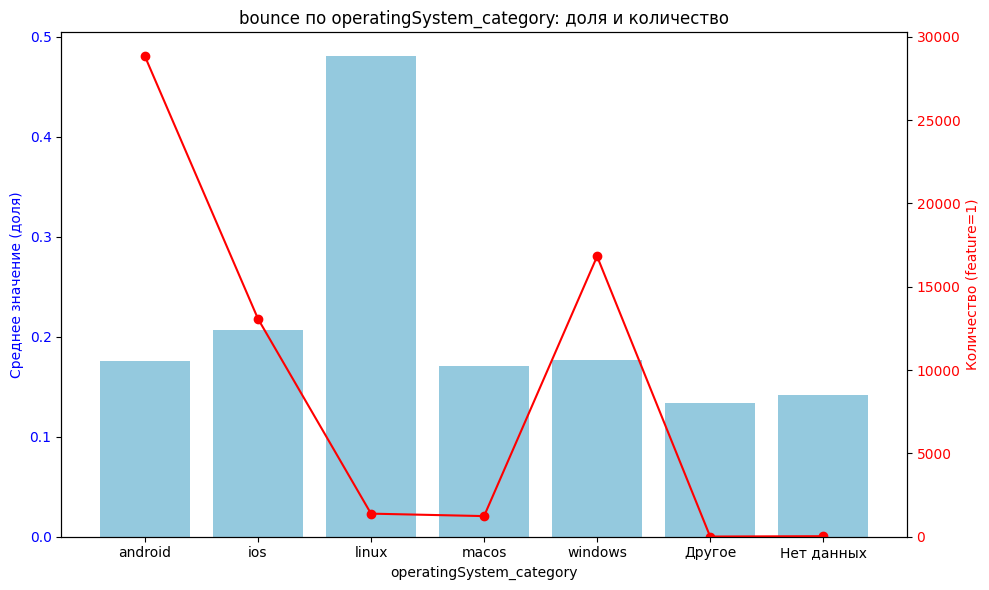

In [ ]:
feature = 'bounce'
category = 'operatingSystem_category'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, lambda x: (x == 1).sum())
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля отказов', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество отказов', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Доля отказов практически одинакова для всех типов устройств (кроме линукса, но их мало)

# 5. Исследования оставленных регистраций

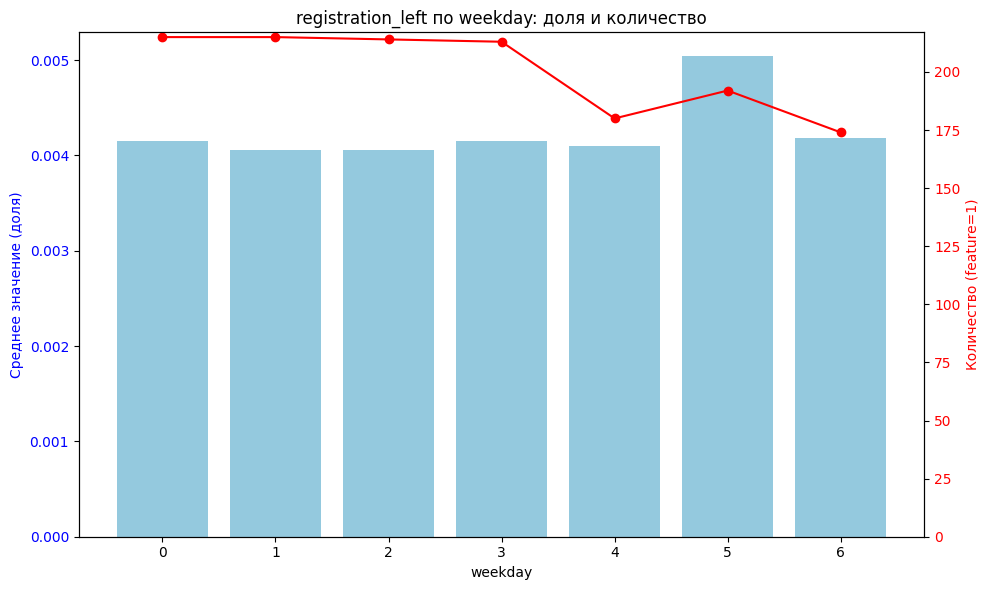

In [ ]:
feature = 'registration_left'
category = 'weekday'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, lambda x: (x == 1).sum())
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля регистраций', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество регистраций', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


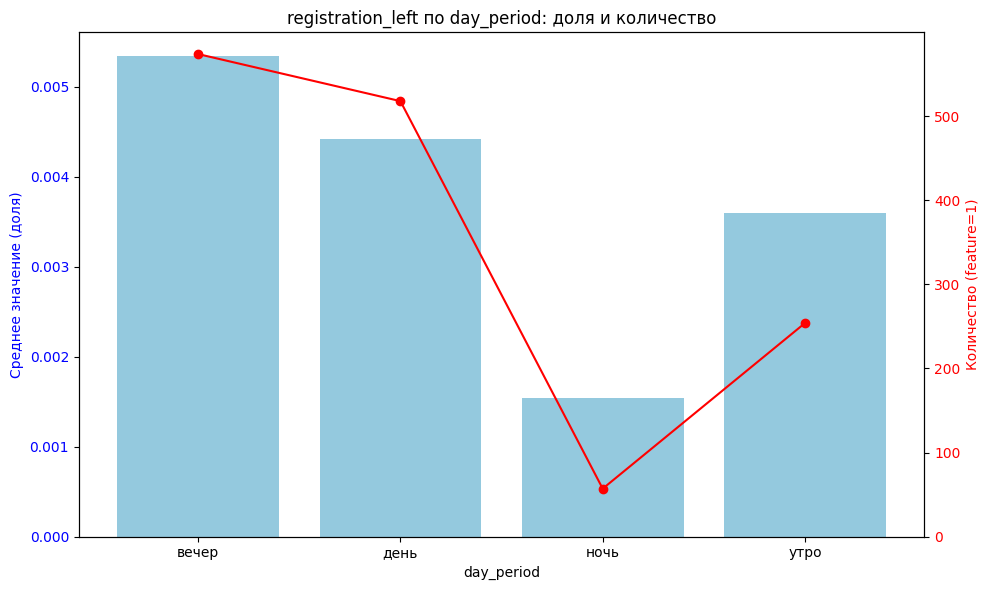

In [ ]:
feature = 'registration_left'
category = 'day_period'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, lambda x: (x == 1).sum())
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля регистраций', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество регистраций', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


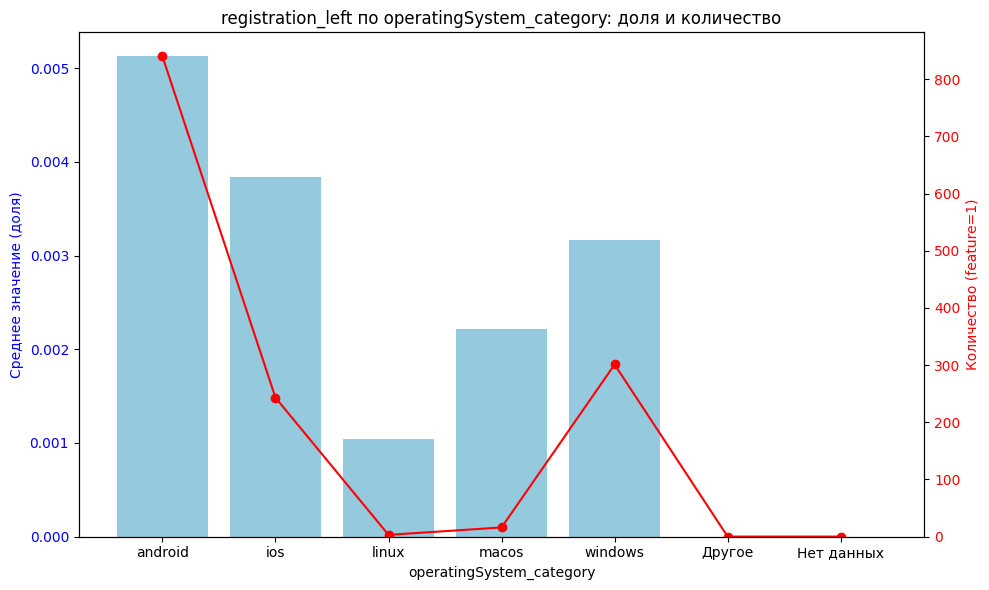

In [ ]:
feature = 'registration_left'
category = 'operatingSystem_category'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, lambda x: (x == 1).sum())
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля регистраций', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество регистраций', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


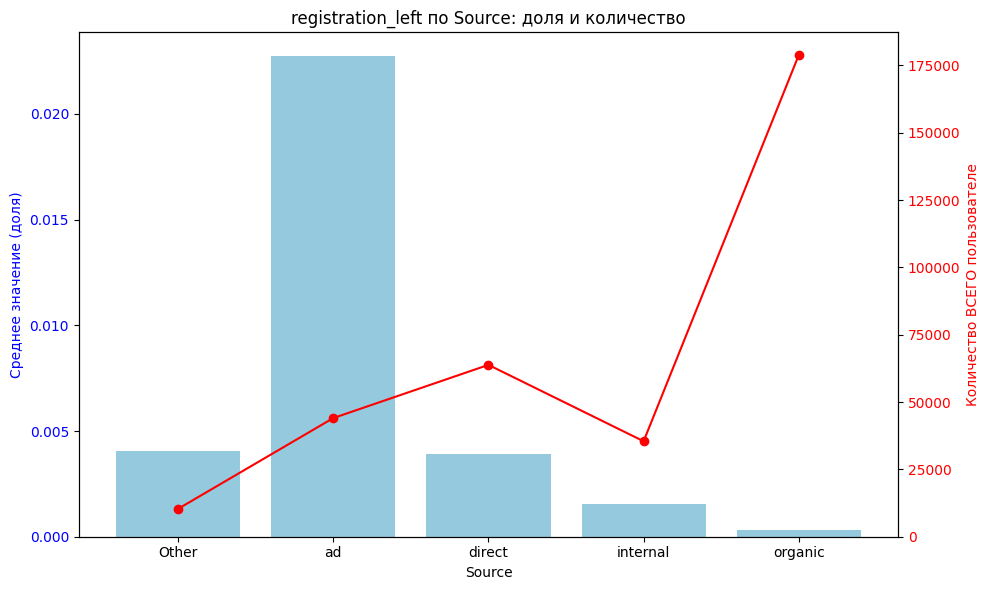

In [ ]:
feature = 'registration_left'
category = 'Source'

grouped = df.groupby(category).agg(
    mean_feature=(feature, 'mean'),
    count_feature=(feature, 'count')
).reset_index()

# График
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=category, y='mean_feature', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля регистраций', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature} по {category}: доля и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[category], grouped['count_feature'], color='red', marker='o')
ax2.set_ylabel('Количество ВСЕГО пользователей', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Выводы по оставленным регистрациям

# 1. Как видели до этого, новые пользователи почти не оставляют регистраций
# 2. Как видели до этого, регистрацию оставляют только после длительных просмотров и после большого кол-ва просмотренных страниц
# 3. Как видели до этого, в период отказов регистрации также временно падали
# 4. Как видели до этого, кол-во регистраций растёт в апреле, осенью и в период проведения кампаний
# 5. Немного выше доля регистраций в субботу. Лучше всего конверсия происходит днем и вечером, в эти периоды и большее кол-во пользователей посещает сайт
# 6. Регистрацию чаще оставляют с мобильных устройств, хотя находятся на сайте чаще с десктопов
# 7. Лучше всего конвертятся с ad. Из оставшихся самая высокая доля с direct; при этом основная часть траффика идёт с organic, но конверсия там минимальна

# 6. Исследование распределений по городам

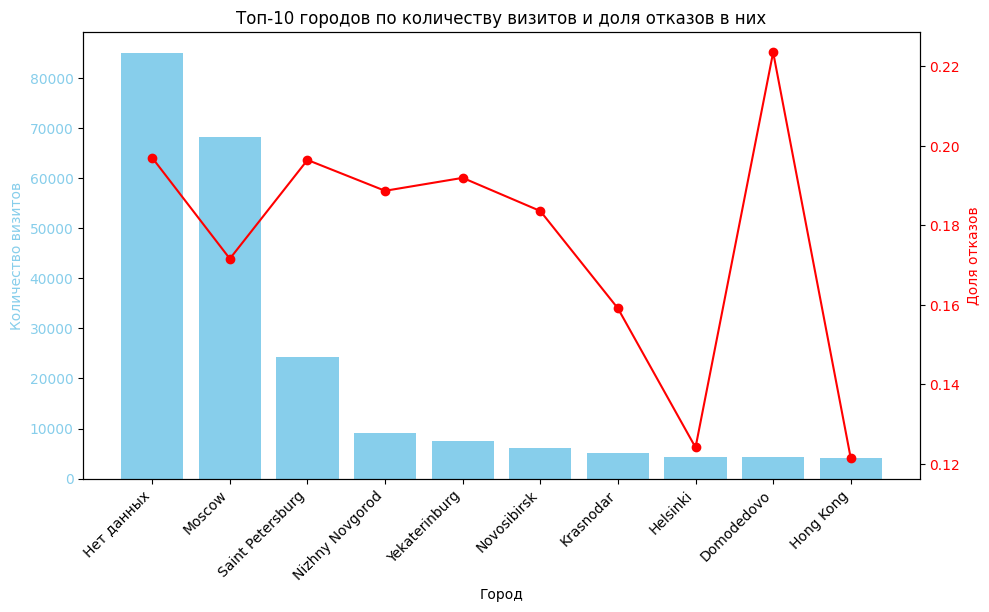

In [71]:
# отказы
stats = df.groupby('regionCity').agg(
    visits=('visitID', 'count'),
    bounce_rate=('bounce', 'mean') 
)

# топ‑10 городов
top10 = stats.sort_values('visits', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(10, 6))

# количество визитов
ax1.bar(top10.index, top10['visits'], color='skyblue', label='Visits')
ax1.set_xlabel('Город')
ax1.set_ylabel('Количество визитов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(top10.index, rotation=45, ha='right')

# доля отказов
ax2 = ax1.twinx()
ax2.plot(top10.index, top10['bounce_rate'], color='red', marker='o', label='Bounce Rate')
ax2.set_ylabel('Доля отказов', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.title('Топ-10 городов по количеству визитов и доля отказов в них')
plt.show()

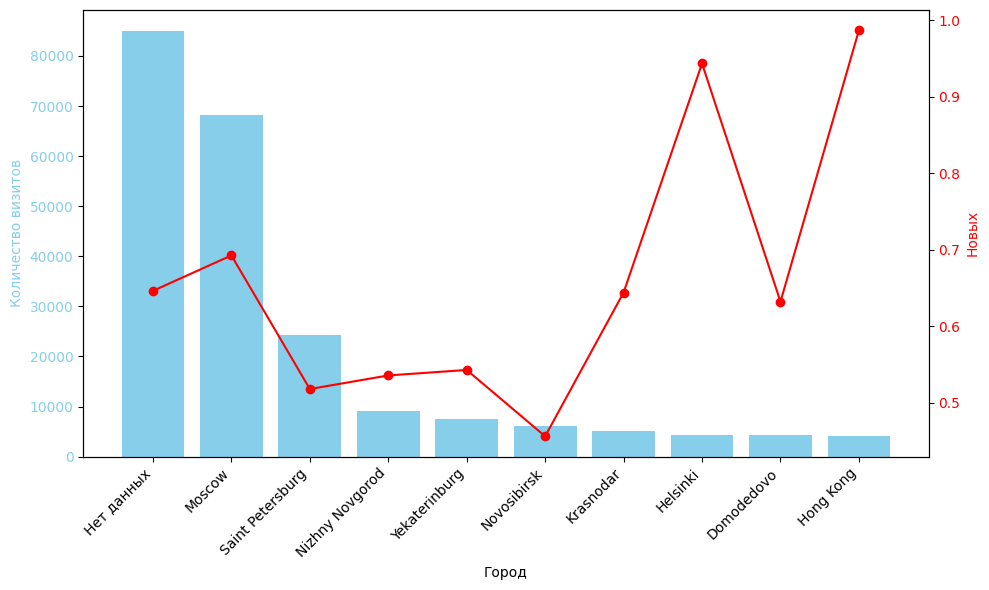

In [ ]:
# новые пользователи
stats = df.groupby('regionCity').agg(
    visits=('visitID', 'count'),
    new_rate=('isNewUser', 'mean') 
)

# топ‑10 городов
top10 = stats.sort_values('visits', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(10, 6))

# количество визитов
ax1.bar(top10.index, top10['visits'], color='skyblue', label='Visits')
ax1.set_xlabel('Город')
ax1.set_ylabel('Количество визитов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(top10.index, rotation=45, ha='right')

# доля отказов
ax2 = ax1.twinx()
ax2.plot(top10.index, top10['new_rate'], color='red', marker='o', label='Новых')
ax2.set_ylabel('Доля новых пользователей', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.title('Топ-10 городов по количеству визитов и новые пользователи в них')
plt.show()

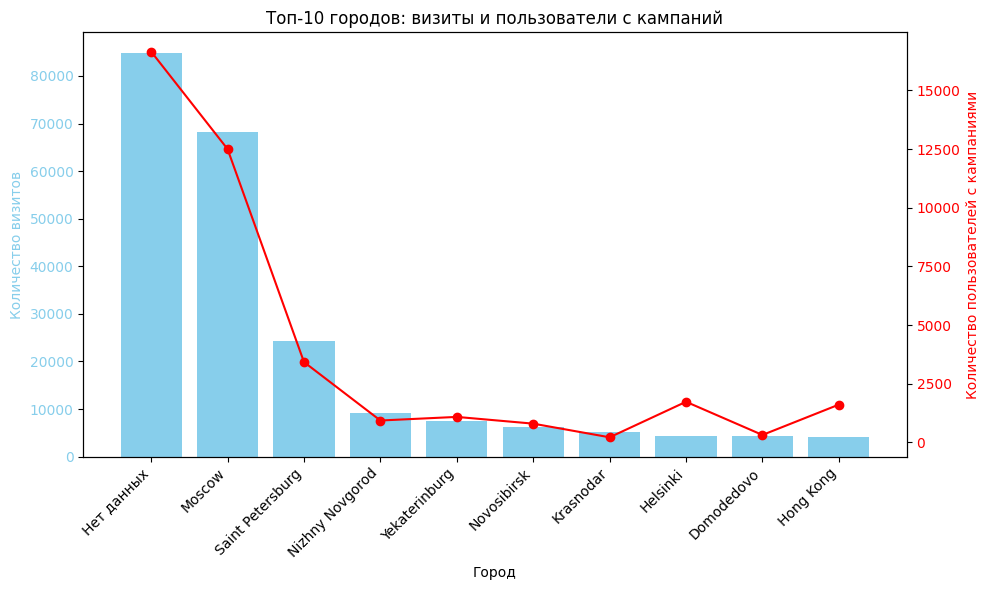

In [72]:
# пользователей с кампаниями
df_filtered = df[df['UTMSource'] != 'Нет данных']

campaign_users = df_filtered.groupby('regionCity')['visitID'].count().rename('campaign_users')

stats = df.groupby('regionCity').agg(
    visits=('visitID', 'count')
)

stats = stats.join(campaign_users, how='left').fillna(0)
top10 = stats.sort_values('visits', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(top10.index, top10['visits'], color='skyblue', label='Визиты')
ax1.set_xlabel('Город')
ax1.set_ylabel('Количество визитов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(top10.index, rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(top10.index, top10['campaign_users'], color='red', marker='o', label='Пользователи с кампаниями')
ax2.set_ylabel('Количество пользователей с кампаниями', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Топ-10 городов: визиты и пользователи с кампаний')
fig.tight_layout()
plt.show()


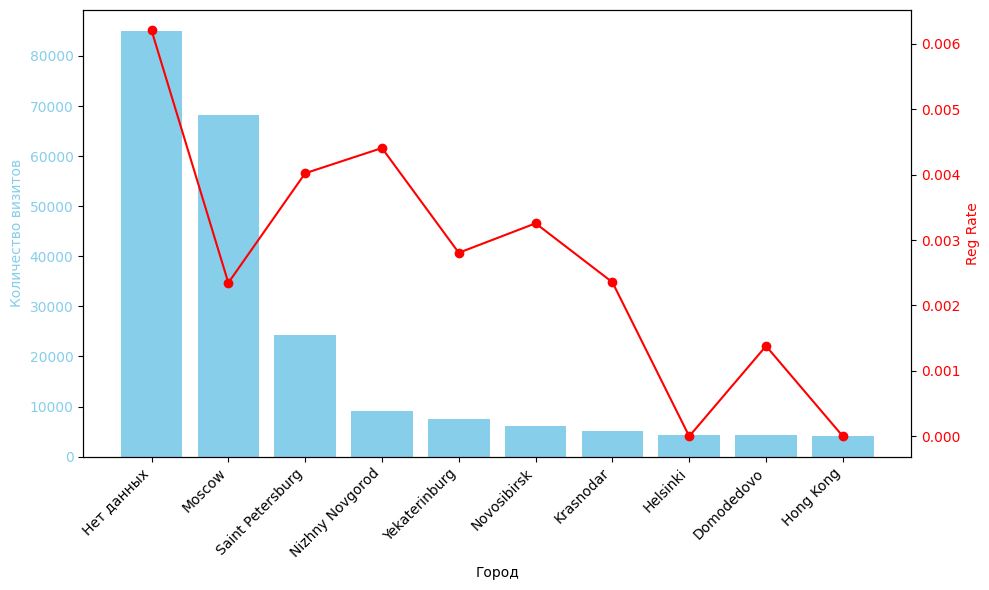

In [839]:
# регистраций
stats = df.groupby('regionCity').agg(
    visits=('visitID', 'count'),
    reg_rate=('registration_left', 'mean') 
)

# топ‑10 городов
top10 = stats.sort_values('visits', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(10, 6))

# количество визитов
ax1.bar(top10.index, top10['visits'], color='skyblue', label='Visits')
ax1.set_xlabel('Город')
ax1.set_ylabel('Количество визитов', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(top10.index, rotation=45, ha='right')

# доля отказов
ax2 = ax1.twinx()
ax2.plot(top10.index, top10['reg_rate'], color='red', marker='o', label='Reg Rate')
ax2.set_ylabel('Reg Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()

# Результаты распределений по городам

# 1. Наибольшее количество пользователей сосредоточено в крупных городах
# 2. Доля отказов распределена равномерно, но необыкновенно большая в Домодедово (вероятно, глушат связь); ниже в Москве и Краснодаре
# 3. Большая доля новых пользователей в Мск и Краснодаре
# 4. Пользователей с кампаний больше всего в Мск и СПб
# 5. Большая доля регистраций в НН, СПб. При этом в НН мало пользователей с кампаний - возможно, кампании в НН работают не так хорошо, но при такой конверсии есть смысл привлекать больше пользователей
# 6. В Мск, несмотря на большое кол-во проведение кампаний и большое кол-во новых пользователей - доля регистраций меньше других городов; вероятно, из-за большого кол-ва конкурентов - есть смысл отстраиваться от них и показывать наши конкурентные преимущества

# Рекомендуемые действия: 
# Рассмотреть масштабирование кампаний в НН — с высокой вероятностью ROI будет выше
# Исследовать причины низких регистраций в Мск, отличия поведения пользователей и отличия кампаний от других городов; сделать конкурентный анализ; затем можно протестировать кампани, отстраиваясь от конкурентов по УТП, дизайну, подходу

# Часть 5. Анализ прогнозируемой метрики - оттока клиентов

# 1. Уберём из анализа оттока тех, кто заходил недавно и просто не успел зайти ещё раз и добавим метку следующего визита

In [ ]:
# рассчитаем, через сколько дней в среднем возвращаются

df_time = df.copy()
df_time = df_time.sort_values(by=['clientID', 'dateTime'])
df_time['next_visit'] = df_time.groupby('clientID')['dateTime'].shift(-1)
df_time['days_to_next'] = (df_time['next_visit'] - df_time['dateTime']).dt.days

valid_days = df_time['days_to_next']
valid_days = valid_days.dropna()
valid_days = valid_days[valid_days != 0]

mean_days = valid_days.mean()
median_days = valid_days.median()
print(f"Среднее: {mean_days:.1f} дней, медиана: {median_days:.1f} дней")

Среднее: 24.0 дней, медиана: 5.0 дней


In [ ]:
# медиана получилась 5 дней; возьмём 1,5 от медианы - получается 7 дней;
# не будем брать в расчёт тех, кто заходил в последние 7 дней, они могли ещё не успеть вернуться

cutoff_date = df['dateTime'].max() - pd.Timedelta(days=7)
df = df[df['dateTime'] <= cutoff_date]

In [ ]:
# Добавляем столбец с меткой, был ли визит после

df = df.sort_values(by=['clientID', 'dateTime'])

df['next_visit'] = df.groupby('clientID')['dateTime'].shift(-1).notna()
df['visits_before'] = df.groupby('clientID').cumcount()
df['days_last_visit'] = (df['date'] - df.groupby('clientID')['date'].shift(1)).dt.days


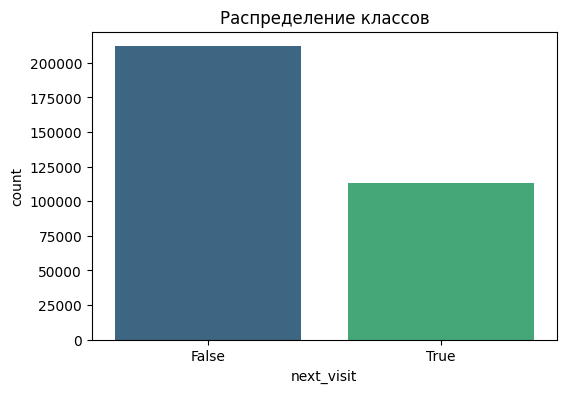

In [ ]:
# оценим распределение классов по наличию следующего визита

plt.figure(figsize=(6, 4))
sns.countplot(x=df['next_visit'], palette='viridis')
plt.title('Распределение классов')
plt.show()

# Наблюдается дисбаланс в рассматриваемых классах - не вернувшихся больше

# 2. Кол-во просмотренных страниц в зависимости от наличия следующего визита

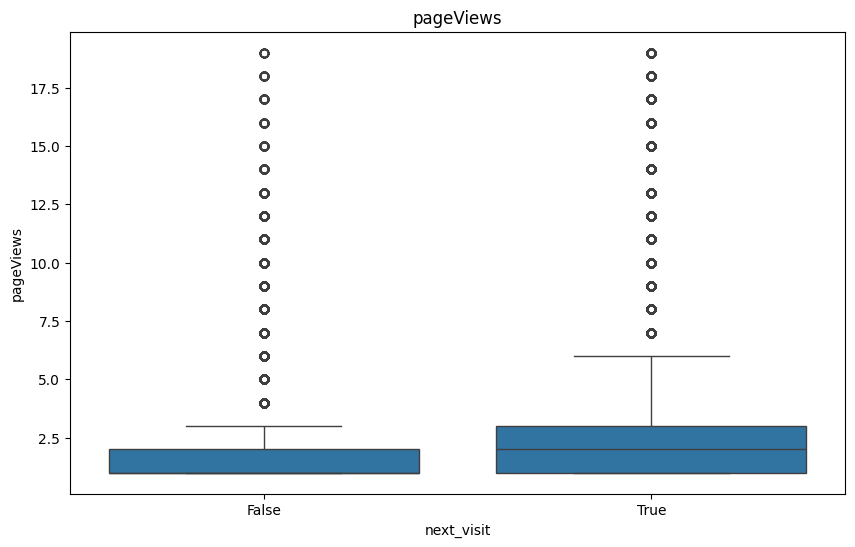

Средний:
next_visit
False    1.504894
True     2.522225
Name: pageViews, dtype: float64


In [844]:
feature = 'pageViews'
filtered_data = df[df[feature] < 20]

plt.figure(figsize=(10, 6))
sns.boxplot(x='next_visit', y=feature, data=filtered_data)
plt.title(feature)
plt.show()

# cредние значения
print("Средний:")
print(filtered_data.groupby('next_visit')[feature].mean())

# 3. Длительность визита в зависимости от наличия следующего визита

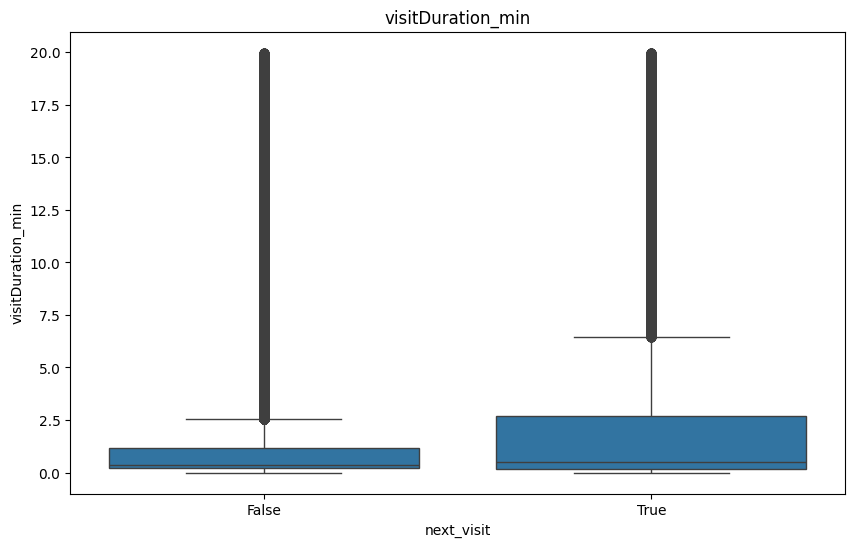

Средний:
next_visit
False    1.385460
True     2.609041
Name: visitDuration_min, dtype: float64


In [845]:
feature = 'visitDuration_min'
filtered_data = df[df[feature] < 20]

plt.figure(figsize=(10, 6))
sns.boxplot(x='next_visit', y=feature, data=filtered_data)
plt.title(feature)
plt.show()

# cредние значения
print("Средний:")
print(filtered_data.groupby('next_visit')[feature].mean())

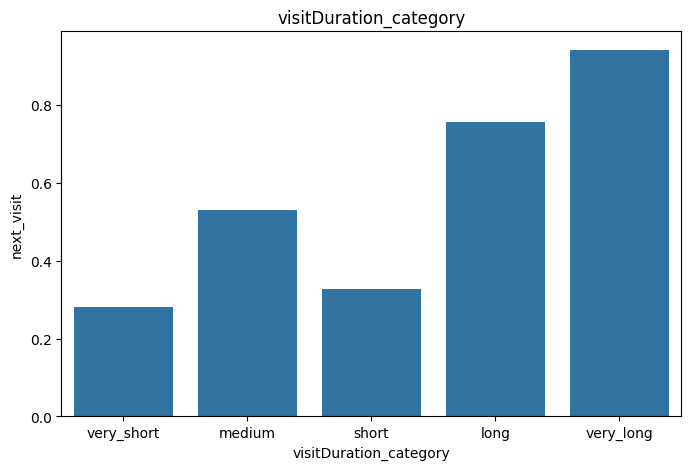

visitDuration_category
visitDuration_category
long          0.756860
medium        0.531299
short         0.327221
very_long     0.942076
very_short    0.280090
Name: next_visit, dtype: float64


In [846]:
feature = 'visitDuration_category'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 4. Наличие следующего визита в зависимости от дня/времени суток посещения

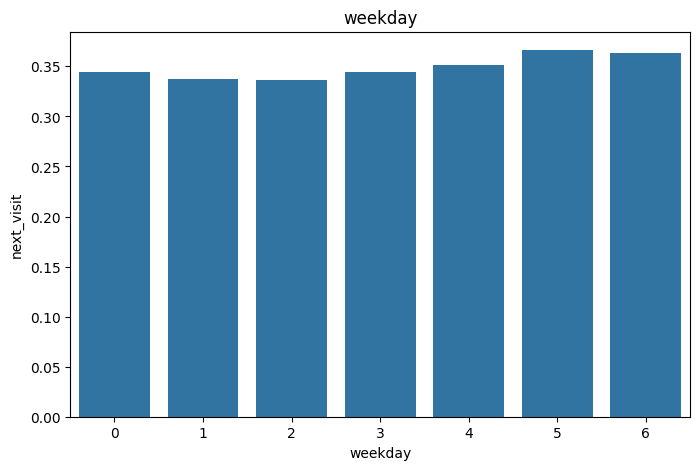

weekday
weekday
0    0.344766
1    0.337870
2    0.336579
3    0.344275
4    0.351767
5    0.366308
6    0.363269
Name: next_visit, dtype: float64


In [847]:
feature = 'weekday'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

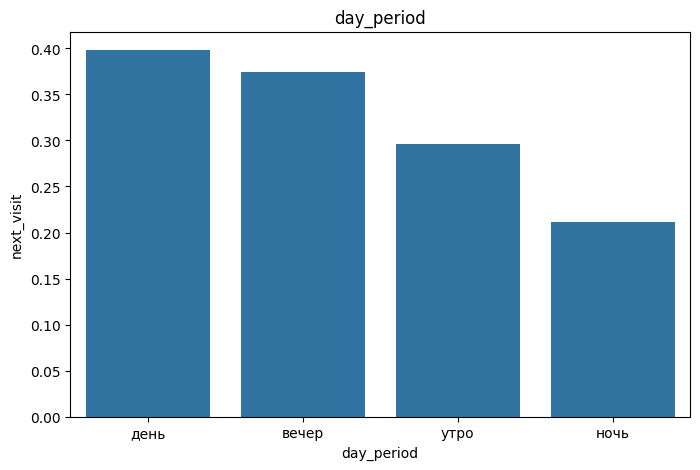

day_period
day_period
вечер    0.374225
день     0.398387
ночь     0.211423
утро     0.296342
Name: next_visit, dtype: float64


In [ ]:
feature = 'day_period'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

print(feature)
print(df.groupby(feature)['next_visit'].mean())

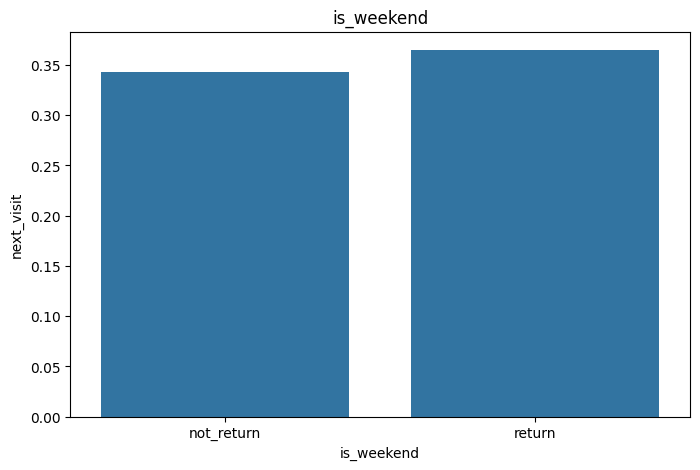

is_weekend
is_weekend
0    0.342728
1    0.364726
Name: next_visit, dtype: float64


In [849]:
feature = 'is_weekend'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.xticks([0, 1], ['not_return', 'return'])
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 5. Наличие следующего визита в зависимости от источника трафика

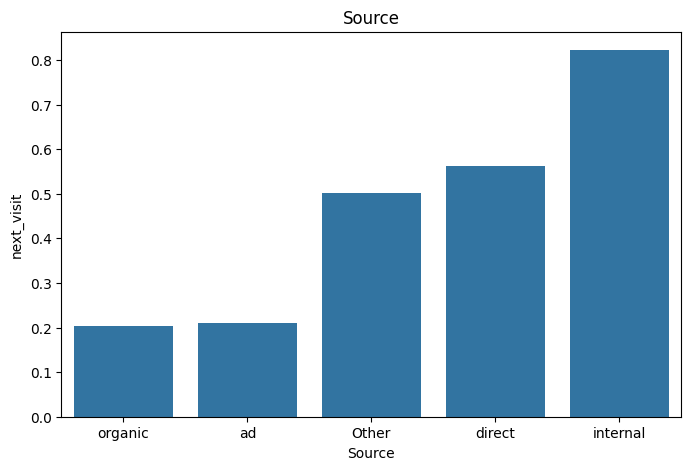

Source
Source
Other       0.502511
ad          0.210733
direct      0.563247
internal    0.822313
organic     0.202847
Name: next_visit, dtype: float64


In [850]:
feature = 'Source'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

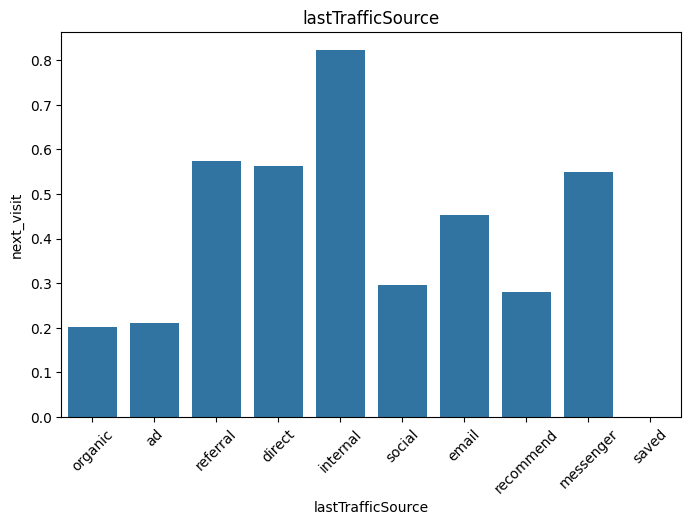

lastTrafficSource
lastTrafficSource
ad           0.210733
direct       0.563247
email        0.451923
internal     0.822313
messenger    0.549763
organic      0.202847
recommend    0.280374
referral     0.573677
saved        0.000000
social       0.295407
Name: next_visit, dtype: float64


In [851]:
feature = 'lastTrafficSource'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.xticks(rotation=45)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

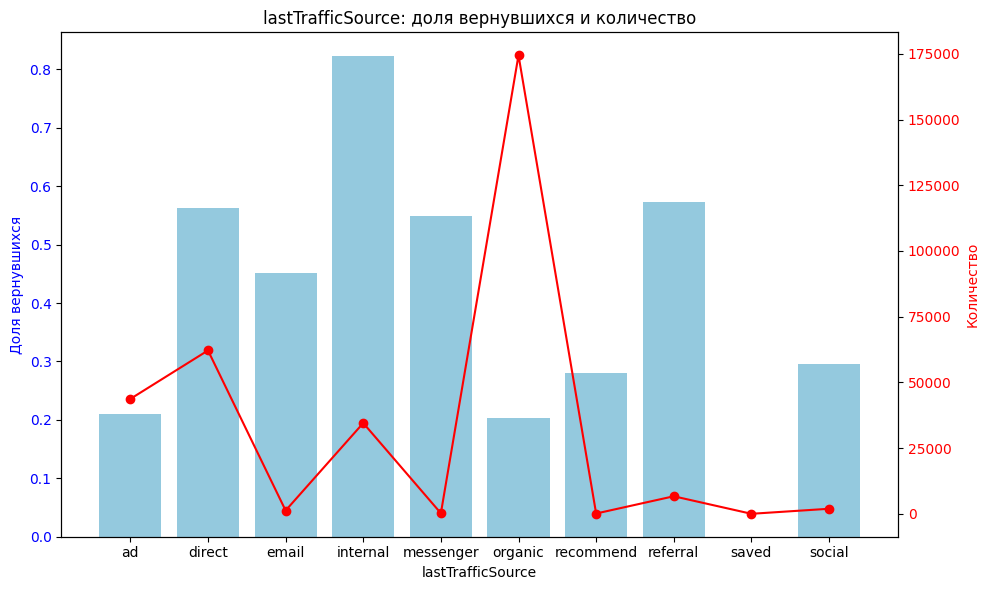

In [ ]:
feature = 'lastTrafficSource'
grouped = df.groupby(feature)['next_visit'].agg(['mean', 'count']).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature, y='mean', data=grouped, ax=ax1, color='skyblue')
ax1.set_ylabel('Доля вернувшихся', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{feature}: доля вернувшихся и количество')

ax2 = ax1.twinx()
ax2.plot(grouped[feature], grouped['count'], color='red', marker='o')
ax2.set_ylabel('Количество вернувшихся', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 6. Наличие следующего визита в зависимости от типа устройства

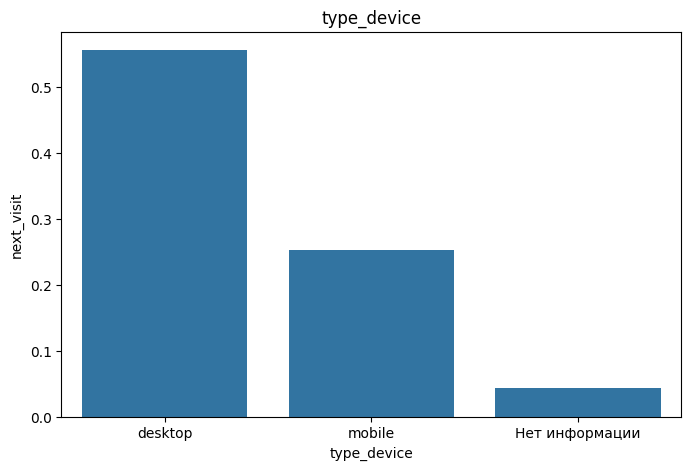

type_device
type_device
desktop           0.556368
mobile            0.252017
Нет информации    0.043210
Name: next_visit, dtype: float64


In [853]:
feature = 'type_device'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 7. Наличие следующего визита в зависимости от ОС

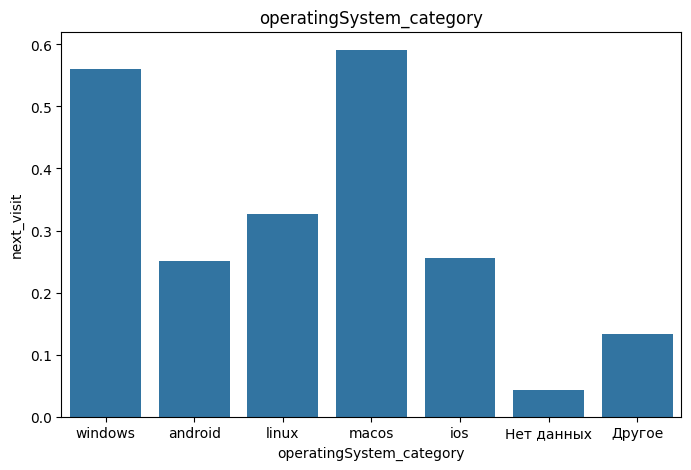

operatingSystem_category
operatingSystem_category
android       0.250791
ios           0.255209
linux         0.326930
macos         0.591179
windows       0.560736
Другое        0.133333
Нет данных    0.043210
Name: next_visit, dtype: float64


In [854]:
feature = 'operatingSystem_category'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 8. Наличие следующего визита в зависимости от наличия кампании и конкретной кампании

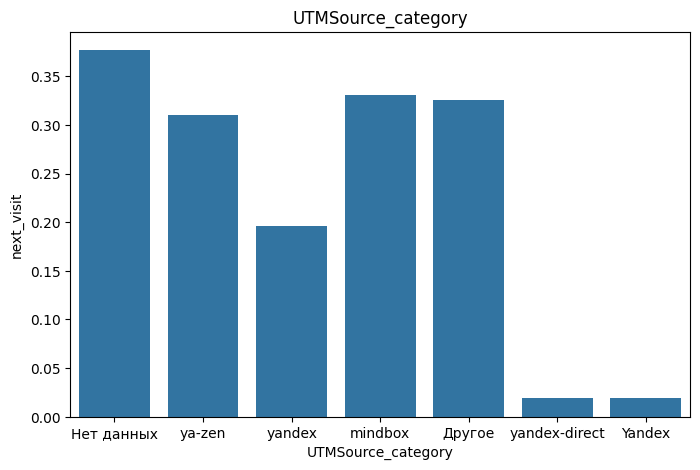

UTMSource_category
UTMSource_category
Yandex           0.019245
mindbox          0.331124
ya-zen           0.309986
yandex           0.196195
yandex-direct    0.019387
Другое           0.325480
Нет данных       0.377047
Name: next_visit, dtype: float64


In [855]:
feature = 'UTMSource_category'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 9. Наличие следующего визита в зависимости от того, новый ли пользователь

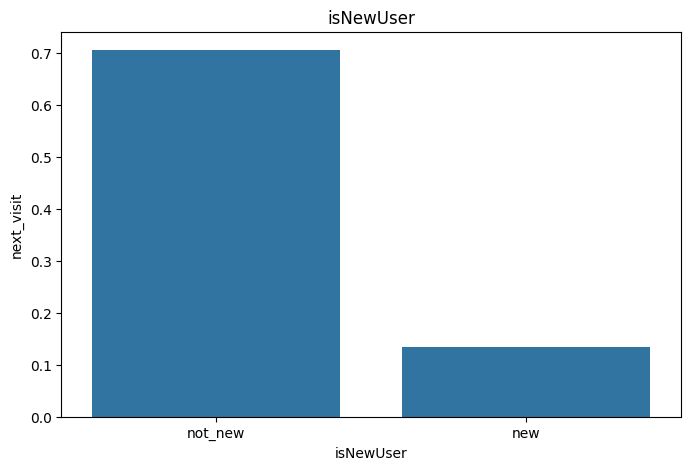

isNewUser
isNewUser
0    0.705030
1    0.133489
Name: next_visit, dtype: float64


In [856]:
feature = 'isNewUser'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.xticks([0, 1], ['not_new', 'new'])
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 10. Наличие следующего визита в зависимости от того, был ли отказ

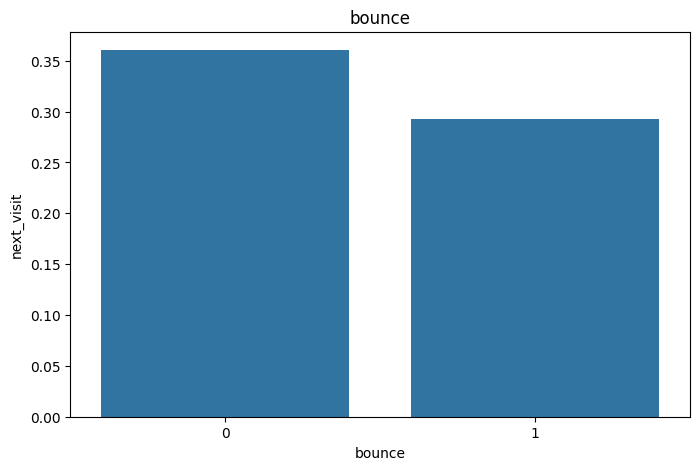

bounce
bounce
0    0.360446
1    0.293042
Name: next_visit, dtype: float64


In [857]:
feature = 'bounce'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 11. Наличие следующего визита в зависимости от того, оставлял ли пользователь регистрацию в целом

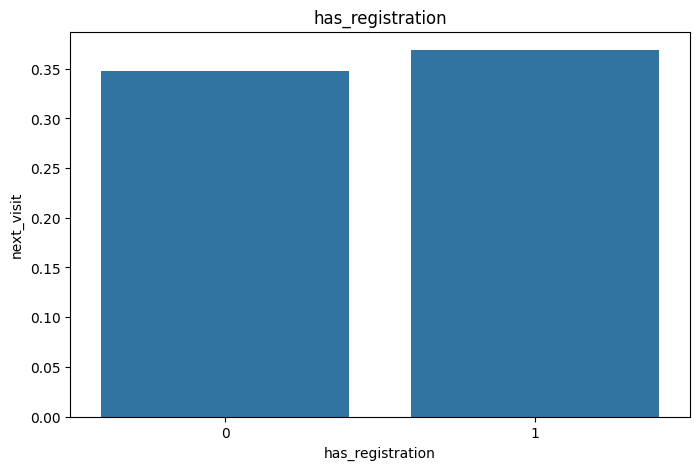

has_registration
has_registration
0    0.347910
1    0.368835
Name: next_visit, dtype: float64


In [858]:
feature = 'has_registration'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 12. Наличие следующего визита в зависимости от того, оставил ли пользователь регистрацию в этой сессии

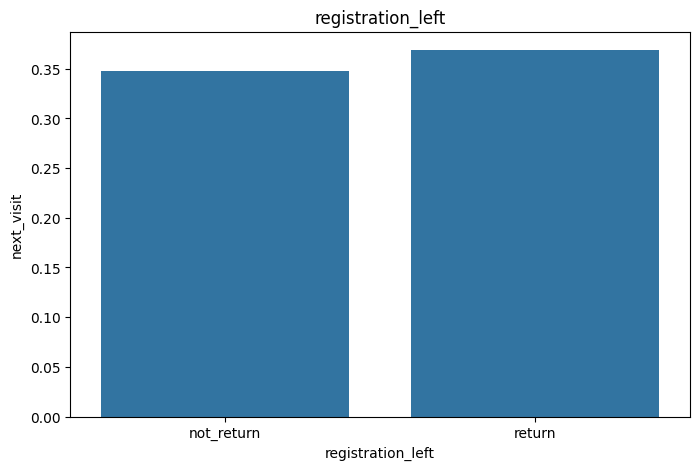

registration_left
registration_left
0    0.347910
1    0.368835
Name: next_visit, dtype: float64


In [859]:
feature = 'registration_left'

plt.figure(figsize=(8, 5))
sns.barplot(x=feature, y='next_visit', data=df, ci=None)
plt.xticks([0, 1], ['not_return', 'return'])
plt.title(feature)
plt.show()

# Точные значения
print(feature)
print(df.groupby(feature)['next_visit'].mean())

# 13. Наличие следующего визита в зависимости от кол-ва посещений до этого

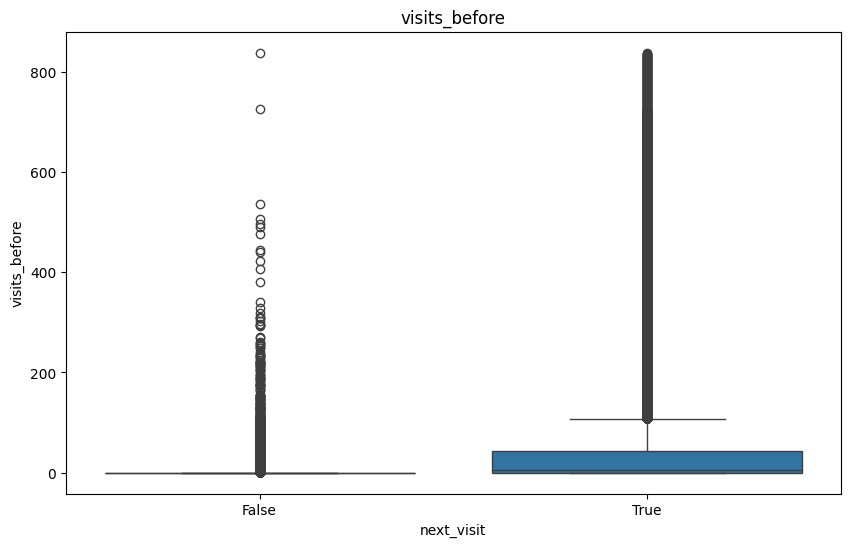

Средний:
next_visit
False     0.533744
True     41.822116
Name: visits_before, dtype: float64


In [860]:
feature = 'visits_before'

plt.figure(figsize=(10, 6))
sns.boxplot(x='next_visit', y=feature, data=df)
plt.title(feature)
plt.show()

# cредние значения
print("Средний:")
print(df.groupby('next_visit')[feature].mean())

# 14. Наличие следующего визита в зависимости от дней с последнего визита

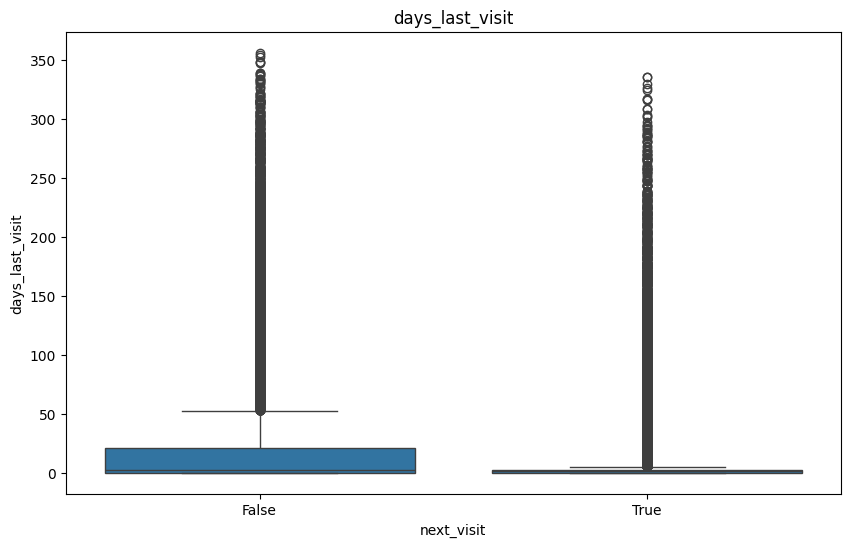

Средний:
next_visit
False    24.603964
True      5.887706
Name: days_last_visit, dtype: float64


In [861]:
feature = 'days_last_visit'

plt.figure(figsize=(10, 6))
sns.boxplot(x='next_visit', y=feature, data=df)
plt.title(feature)
plt.show()

# cредние значения
print("Средний:")
print(df.groupby('next_visit')[feature].mean())

# Результаты исследования факторой, влияющих на отток пользователей

# 1. Больше просмотренных страниц - больше вероятность возвращения
# 2. Больше времени визита - больше вероятность возвращения
# 3. День недели не влияет на возврат; но вероятность возвращения выше, если заходят днём или вечером
# 4. Основные каналы, после которых возвращаются: direct, internal
# refferal, messenger, email - возвращаются часто, но и людей там мало
# 5. Чаще заходят с мобильных устройств, но возвращаются чаще с десктопа
# 6. Операционная система не влияет на отток
# 7. Пользователи пришедшие не в результате кампании, возвращаются чаще всего; хорошие результаты в плане возврата у yandex-zen и mindbox;
# Рекомендуемые действия: есть гипотеза, что кампании привлекают “холодную” ЦА; сегментировать и персонализировать посадочные страницы

# 8. Новые пользователи возвращаются ГОРАЗДО реже
# 9. Это интересно, но отказ не влияет на возврат
# 10. Наличие регистрации не влияет на возврат
# 11. У тех, кто возвращался, визитов до этого было существенно больше
# 12. Есть примерно 5 дней, когда пользователи возвращаются с большой вероятностью; но чем больше дней проходит, тем реже возвращаются

# 15. Построим тепловую карту корреляций

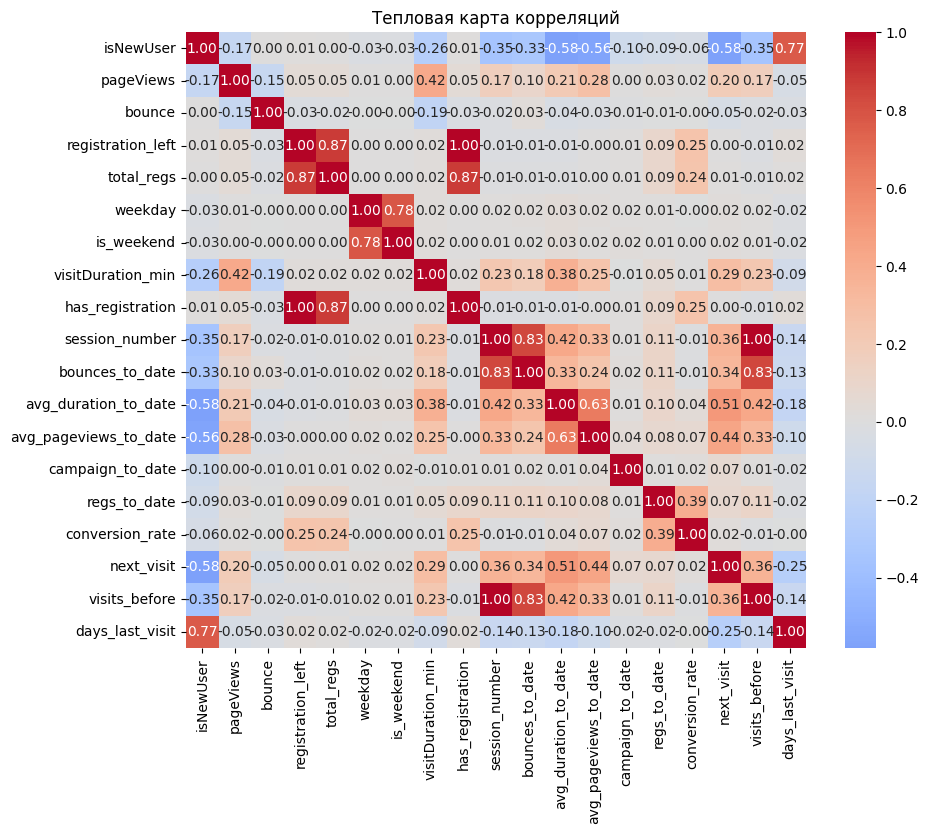

In [862]:
df_matrix = df.copy()
df_matrix.drop([
    'visitID',
    'visitDuration',
    'clientID',
    'counterUserIDHash',
    'visits_to_date'
    ], axis=1, inplace=True)

plt.figure(figsize=(10, 8))
corr_matrix = df_matrix.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляций')
plt.show()

# Выводы по матрице корреляций

# 1. Сильно коррелируют:
- isNewUser и days_last_visit - удалим days_last_visit
- pageViews и visitDuration/visitDuration_min и visits_before - что логично, но иногда эти метрики ведут себя по-разному
- registration_left и has_registration и total_regs - логично; заменяем total_regs на has_registration; возможно, в дальнейшем стоит удалить одно
- weekday и is_weekend - возможно, стоит удалить одно

# 2. На таргет влияют:
- pageViews
- isNewUser (отриц)
- visitDuration_min
- visits_before

# 3. Низкая корреляция с таргетом (возможно, стоит удалить)
- bounce
- registration_left и has_registration
- weekday и is_weekend

# 16. Добавим доп метрики для модели

In [863]:
# Общее количество визитов и уникальных пользователей
print(f'Всего визитов: {df['visitID'].count()}')
print(f'Всего пользователей: {df['clientID'].nunique()}')
print(f'Среднее кол-во визитов на пользователя: {df['visitID'].count()/df['clientID'].nunique()}')

# Среднее количество просмотренных страниц на визит
print(f'Ср просмотрено страниц за визит: {df['pageViews'].mean()}')

# Среднее время визита
print(f'Ср время визита: {df['visitDuration_min'].mean()}')

# Процент новых пользователей
print(f'% новых пользователей: {df[df['isNewUser'] == 1]['clientID'].nunique()/df['clientID'].nunique()}')

Всего визитов: 324988
Всего пользователей: 211892
Среднее кол-во визитов на пользователя: 1.5337436052328546
Ср просмотрено страниц за визит: 1.983660935172991
Ср время визита: 4.262771958759503
% новых пользователей: 0.9425556415532441


# Выводы по исследованию:

# 1. Если смотреть по стране, по данным 23-24 года количество школьников 5-9 классов - 8 875 300, 10-11 классов - 1 345 800; из них на сайт заходило около 2,1 % - этот показатель точно можно увеличивать, очень много школьников не знают про образовательный центр

# 2. Количество визитов по возможности стоило бы сравнить с другими образовательными компаниями

# 3. В среднем пользователь заходит 1,5 раза - то есть примерно половина затем не возвращается - это плохо, нужно работать с оттоком

# 4. В среднем на просмотр тратят 4 минуты и смотрят около 2 страниц - нужно сегментировать пользователей и выводить им самые актуальные страницы, также делать удобную навигацию, чтобы за это время они получали самую полезную информацию - для этого стоит делать глубокий анализ просмотра страниц // с каких уходили // на какие не заходят // что пользователи ищут на сайте

# 5. Очень много новых пользователей - привлечение работает, это хорошо, но с новыми пользователями на сайте можно работать по-другому, постепенно ознакамливая их с компанией

# Итоговые рекомендации

# Улучшение сайта и продукта:
1. Повысить конверсию новых пользователей — показывать короткие, содержательные страницы с явными УТП и призывом к регистрации.
2. Адаптировать UX для мобильных устройств — улучшить структуру, навигацию и производительность.
3. Внедрить триггерные механизмы — всплывающие окна с предложением регистрации после длительного просмотра.
4. Работа с городами с высокой конверсией — масштабировать кампании в регионы типа НН.
5. В Москве выделяться на фоне конкурентов — через УТП и сравнительные преимущества.

# Дальнейшие исследования:
1. Причины отказов и падений регистраций — сегментировать по страницам, анализ причин по источникам, устройствам.
2. Поведение новых пользователей — сделать тепловые карты и анализ кликов, чтобы понять потребности.
3. Качество кампаний — отслеживание UTM-меток, воронок, проверка трекинга.
4. Пути пользователя — построение воронок и drop-off точек.
5. Глубинные интервью или юзабилити-тесты — чтобы понять реальные барьеры на пути к регистрации.